# Prediction challenge

### Predict the demand for the bike-sharing system (number of dropoffs and pickups)

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

f=pd.read_csv("../data/Trips_2018.csv")


In [74]:
# step 1: customize the data table

print(f.dtypes)

f.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
f['starttime']=pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime']=pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f['usertype']=pd.Categorical(f['usertype'])
f['gender']=pd.Categorical(f['gender'])
f['start_station_id']=pd.Categorical(f['start_station_id'])
f['end_station_id']=pd.Categorical(f['end_station_id'])

bad_idx = f.index[f.isna().any(axis=1)]
print(bad_idx.tolist())
rows_with_na = f[f.isna().any(axis=1)]
print("rows_with_na first", rows_with_na)

f = f.dropna()

print(f.dtypes)
print(f)

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object
[10413518, 10413697, 10415434, 10415668, 10417031, 10417714, 10417770, 10421216, 10421276, 10422411, 10422596, 10422885, 10422892, 10423047, 10423230, 10423232, 10423388, 10423461, 10423832, 10423867, 10423879, 10423981, 10424026, 10424117, 10424185, 10424278, 10424294, 10424452, 10424591, 10425255, 10425520, 10425626, 10425772, 10426135, 10426607, 10427815, 10427993, 10428027, 10428296, 10428504, 10428784, 10428794, 10430531, 10433528, 10436246, 10438241, 10440685, 10443234, 10444360, 10444

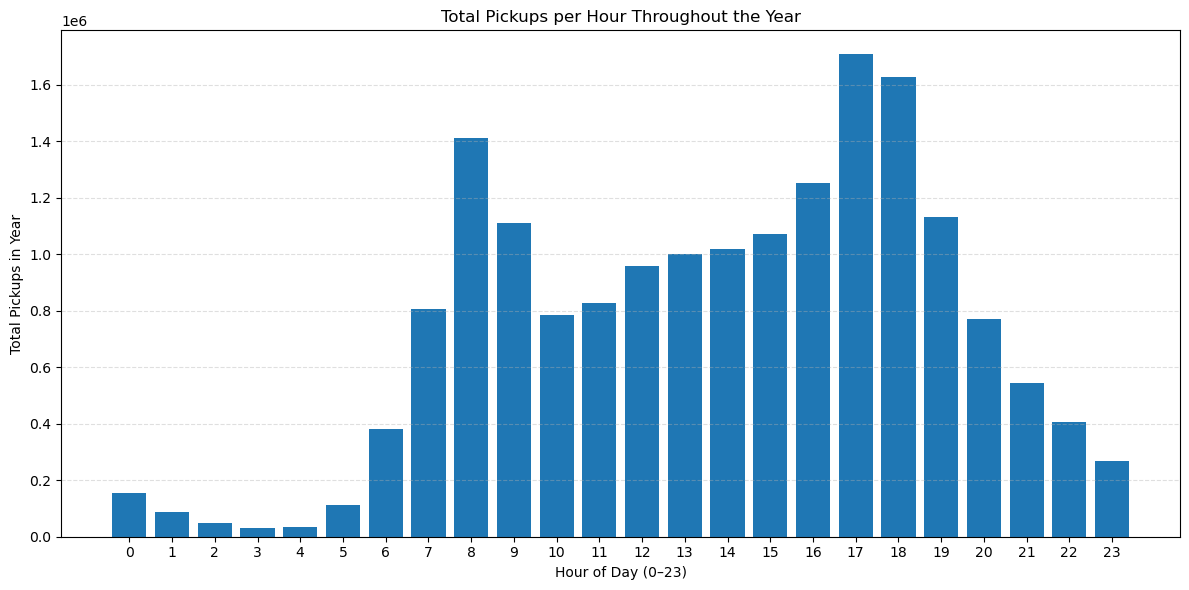

In [75]:
# Start by ploting the total pickup for each hour througout the year
# create an hour column
f['hour'] = f['starttime'].dt.hour

# --- Compute total pickups per hour ---
hourly_counts = f.groupby('hour').size()

# Ensure all 24 hours exist
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Pickups in Year")
plt.title("Total Pickups per Hour Throughout the Year")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

1) Cluster the stations spatially (nearby departing stations should be grouped together)
in no less than 20 clusters. Tasks 2 and 3 will be based on this clustering, and they
should be completed for at least two clusters (more is preferable) so that you can
compare their respective results and discuss them

In [76]:
from sklearn.cluster import KMeans

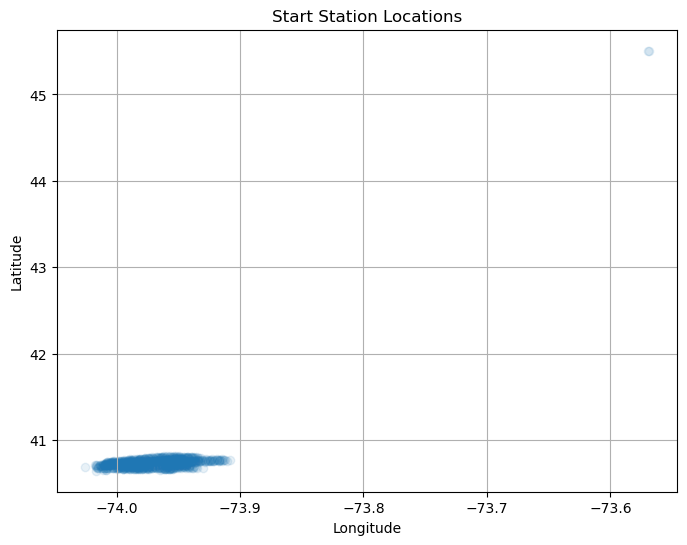

In [77]:
# Create a new DataFrame with start station ID and coordinates, then plot the locations
f_cluster = f[['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id']]
f_cluster = f_cluster.drop_duplicates(subset='start_station_id')


plt.figure(figsize=(8, 6))
plt.scatter(f_cluster['start_station_longitude'], f_cluster['start_station_latitude'], alpha=0.1)

plt.title('Start Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [78]:
#There appears to be an outlier station far away from the other ones, let's find out which one it is and remove it
outlier_condition = (f_cluster['start_station_latitude'] > 41)
outlier_stations = f_cluster[outlier_condition]
print("Outlier stations:\n", outlier_stations)

Outlier stations:
        start_station_id  start_station_latitude  start_station_longitude  \
676612           3488.0               45.506364               -73.569463   
714485           3650.0               45.506264               -73.568906   

       end_station_id  
676612         3488.0  
714485         3650.0  


In [79]:
#Based on the latitude and longitude, stations 3488 and 3650 are located in Montreal, 
# so we will remove them from the clustering dataset and the original one
f_cluster = f_cluster[~outlier_condition]
f = f[f['start_station_latitude'] <= 41]


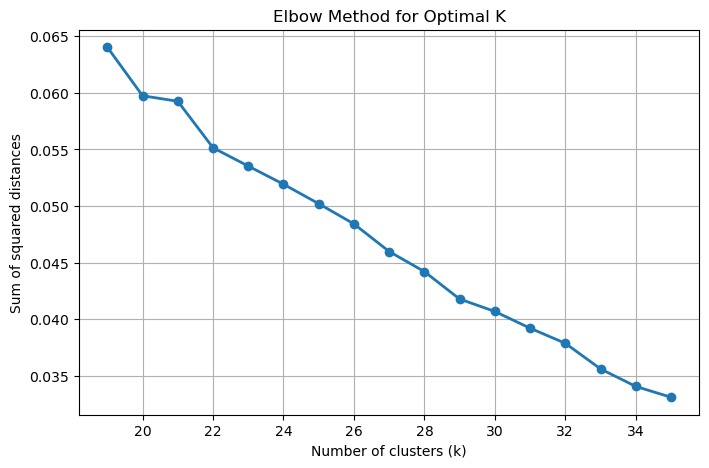

In [80]:
#Now, let's use the elbow method to determine the optimal number of clusters (k)
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

k_values = range(19, 36)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'o-', linewidth=2)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()


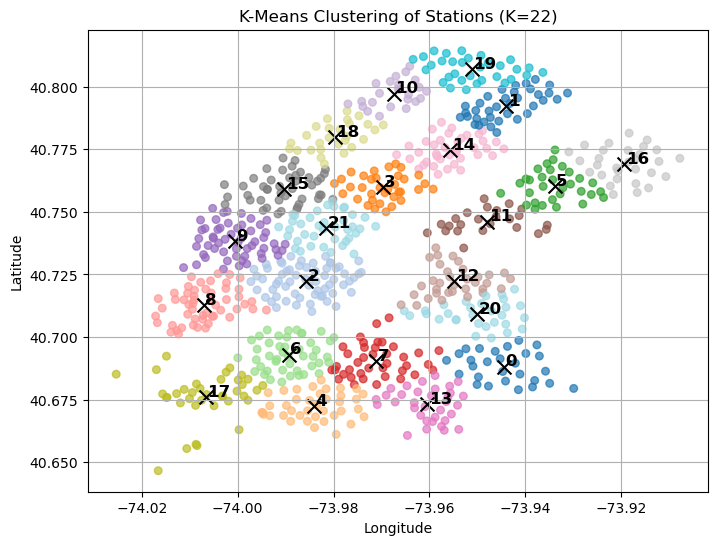

In [81]:
#We observe that k=22 should be a good choice for the number of clusters.

# Let's run the clustering and look at how the clusters look

# Extract coordinates
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

# Run K-Means with 22 clusters
kmeans = KMeans(n_clusters=22, random_state=42)
f_cluster['cluster'] = kmeans.fit_predict(coords)

# Get cluster centers
centers = kmeans.cluster_centers_

# Plot data points colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(
    f_cluster['start_station_longitude'],
    f_cluster['start_station_latitude'],
    c=f_cluster['cluster'], cmap='tab20', s=30, alpha=0.7
)

# Plot cluster centers
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=100, marker='x'
)

# Add numeric labels at each cluster center
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon + 0.0003, lat + 0.0003,   # small offset
        str(i), 
        fontsize=12, fontweight='bold', color='black'
    )

plt.title('K-Means Clustering of Stations (K=22)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [86]:
# We want to only look at the clusters that make up the island of Manhattan
# We remove the other clusters from both f_cluster and f

clusters_to_keep = [2,8,9,15,21]

# Normalize dtypes on keys before building merge
f = f.copy()
f['start_station_id'] = f['start_station_id'].astype(str)
f['end_station_id']   = f['end_station_id'].astype(str)

f_cluster = f_cluster.copy()
f_cluster['start_station_id'] = f_cluster['start_station_id'].astype(str)

stations_to_keep = f_cluster.loc[
    f_cluster['cluster'].isin(clusters_to_keep),
    'start_station_id'
].unique()

f = f[
    f['start_station_id'].isin(stations_to_keep) |
    f['end_station_id'].isin(stations_to_keep)
].copy()


2) You are expected to build a prediction model that, at the end of a day, allows to
predict what the demand for a cluster of stations will be over the next 24 hours – i.e.
not the total demand for the next day, but how the time-series of the demand will look
like for the next day (e.g., given demand data until midnight of day 1, predict the
number of pickups for all 1h intervals (12-1am, 1-2am, 6-7am, 7-8am, …, 11-12pm)
in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the
departures (pickups). You should use a time aggregation of one hour or less. You
can choose to use two different models or a single one to predict both. It is up to you
to determine the most effective way to formulate this problem as a machine learning
problem. You should not shuffle the data. You should instead use the data from
January to October (included) to train your model, and the data from November and
December as a test set. You can use any model you want

In [87]:
f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'cluster': 'start_cluster'}),
    on='start_station_id',
    how='left'
)

f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'start_station_id': 'end_station_id', 'cluster': 'end_cluster'}),
    on='end_station_id',
    how='left'
)

for col in ['start_cluster', 'end_cluster']:
    f[col] = pd.to_numeric(f[col], errors='coerce').astype('Int64')

In [89]:
full_idx = pd.date_range(f['starttime'].min().floor('H'),
                         f['starttime'].max().ceil('H'),
                         freq='H')


def hourly_series_from_trips(df, time_col, cluster_col, cluster_id):
    """Return a single hourly Series (DatetimeIndex, freq='h') for one cluster."""
    s = (df.loc[df[cluster_col] == cluster_id, time_col]
           .dt.floor('H')
           .value_counts()
           .sort_index())
    s.index.name = 'timestamp'
    s = s.reindex(full_idx, fill_value=0).astype(int) # keep rows where there are now pickups/dropoffs
    s.name = f'{cluster_col}_{cluster_id}'
    return s

pickup_series  = {c: hourly_series_from_trips(f, 'starttime', 'start_cluster', c)
                  for c in clusters_to_keep}
dropoff_series = {c: hourly_series_from_trips(f, 'stoptime',  'end_cluster',   c)
                  for c in clusters_to_keep}


/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/4007237222.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(f['starttime'].min().floor('H'),
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/4007237222.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f['starttime'].max().ceil('H'),
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/4007237222.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/4007237222.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/4007237222.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, p

In [121]:
# PICKUPS
pick = (f.loc[f['start_cluster'].isin(clusters_to_keep), ['starttime','start_cluster']]
          .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
          .value_counts(['timestamp','start_cluster'])
          .rename('count')
          .reset_index())

# Build all (timestamp, cluster) combos, then left-join and fill 0
full_pairs = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','start_cluster']
    ).to_frame(index=False)
)

pickup_all = (
    full_pairs.merge(pick, on=['timestamp','start_cluster'], how='left')
              .fillna({'count': 0})
              .astype({'count':'int64'})
              .set_index(['timestamp','start_cluster'])
              .sort_index()
)

# DROPOFFS
drop = (f.loc[f['end_cluster'].isin(clusters_to_keep), ['stoptime','end_cluster']]
          .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))
          .value_counts(['timestamp','end_cluster'])
          .rename('count')
          .reset_index())

full_pairs_d = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','end_cluster']
    ).to_frame(index=False)
)

dropoff_all = (
    full_pairs_d.merge(drop, on=['timestamp','end_cluster'], how='left')
                .fillna({'count': 0})
                .astype({'count':'int64'})
                .set_index(['timestamp','end_cluster'])
                .sort_index()
)


/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/1095759283.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/1095759283.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))


In [122]:
pickup_all = pickup_all.copy()  # optional, to avoid modifying in-place

# Extract hour of day and weekday
pickup_all['hour'] = pickup_all.index.get_level_values('timestamp').hour
pickup_all['weekday'] = pickup_all.index.get_level_values('timestamp').weekday

In [123]:
dropoff_all = dropoff_all.copy()

dropoff_all['hour'] = dropoff_all.index.get_level_values('timestamp').hour
dropoff_all['weekday'] = dropoff_all.index.get_level_values('timestamp').weekday


In [124]:
# Create dummy variables for weekday
weekday_dummies_p = pd.get_dummies(pickup_all['weekday'], prefix='weekday')
weekday_dummies_d = pd.get_dummies(dropoff_all['weekday'], prefix='weekday')

# Join back to the original dataframe
pickup_all = pickup_all.join(weekday_dummies_p)
dropoff_all = dropoff_all.join(weekday_dummies_d)

In [125]:
# Change from True/False to 1/0
weekday_cols_p = [col for col in pickup_all.columns if col.startswith('weekday_')]
pickup_all[weekday_cols_p] = pickup_all[weekday_cols_p].astype(int)
weekday_cols_d = [col for col in dropoff_all.columns if col.startswith('weekday_')]
dropoff_all[weekday_cols_d] = dropoff_all[weekday_cols_d].astype(int)


In [126]:
# Change the name of dummy columns to actual days
weekday_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Identify weekday dummy columns
weekday_cols_p = [col for col in pickup_all.columns if col.startswith('weekday_')]
weekday_cols_d = [col for col in dropoff_all.columns if col.startswith('weekday_')]

# Build a renaming dict
rename_dict_p = {f'weekday_{i}': name for i, name in weekday_map.items() if f'weekday_{i}' in weekday_cols_p}
rename_dict_d = {f'weekday_{i}': name for i, name in weekday_map.items() if f'weekday_{i}' in weekday_cols_d}

# Rename the columns
pickup_all = pickup_all.rename(columns=rename_dict_p)
dropoff_all = dropoff_all.rename(columns=rename_dict_d)

In [127]:
# Drop 'weekday' column from both dataframes
pickup_all = pickup_all.drop(columns=['weekday'])
dropoff_all = dropoff_all.drop(columns=['weekday'])

In [128]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res


In [130]:
pickup_lagged = buildLaggedFeatures(pickup_all, ['count'], lag=168, dropna=True)
dropoff_lagged = buildLaggedFeatures(dropoff_all, ['count'], lag=168, dropna=True)

In [131]:
def my_plot(regr, x, y, size=0.1):

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean absolute error    
    print("Mean Absolute error (MAE): %.2f"% np.mean(abs(regr.predict(x) - y)))
    # The mean squared error
    print("Root Mean squared error: %.2f"
          % np.sqrt(np.mean((regr.predict(x) - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
          
    # Plot outputs
    plt.scatter(y, regr.predict(x), color='blue',linewidth=3)
    plt.plot([0, 5500], [0, 5500], color="red")
    plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
    plt.xlabel("observed")
    plt.ylabel("predicted")
    
    plt.show()

In [134]:
# Split into train and test sets
cutoff = pd.Timestamp('2018-10-31 23:59:59')
pickup_train = pickup_lagged[pickup_lagged.index.get_level_values('timestamp') <= cutoff]
pickup_test  = pickup_lagged[pickup_lagged.index.get_level_values('timestamp') >  cutoff]
dropoff_train = dropoff_lagged[dropoff_lagged.index.get_level_values('timestamp') <= cutoff]
dropoff_test  = dropoff_lagged[dropoff_lagged.index.get_level_values('timestamp') >  cutoff]

In [136]:
pickup_train.head()

count  hour  Monday  Tuesday  Wednesday  \
timestamp           start_cluster                                            
2018-01-02 09:00:00 15               190     9       0        1          0   
                    21               212     9       0        1          0   
2018-01-02 10:00:00 2                 92    10       0        1          0   
                    8                 40    10       0        1          0   
                    9                100    10       0        1          0   

                                   Thursday  Friday  Saturday  Sunday  \
timestamp           start_cluster                                       
2018-01-02 09:00:00 15                    0       0         0       0   
                    21                    0       0         0       0   
2018-01-02 10:00:00 2                     0       0         0       0   
                    8                     0       0         0       0   
                    9                     0       0         0       0   

                                   count_lag1  ...  count_lag159  \
timestamp           start_cluster              ...                 
2018-01-02 09:00:00 15                  191.0  ...          16.0   
                    21                  190.0  ...          17.0   
2018-01-02 10:00:00 2                   212.0  ...           5.0   
                    8                    92.0  ...          14.0   
                    9                    40.0  ...           7.0   

                                   count_lag160  count_lag161  count_lag162  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     13.0          31.0           7.0   
                    21                     16.0          13.0          31.0   
2018-01-02 10:00:00 2                      17.0          16.0          13.0   
                    8                       5.0          17.0          16.0   
                    9                      14.0           5.0          17.0   

                                   count_lag163  count_lag164  count_lag165  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     32.0          11.0          13.0   
                    21                      7.0          32.0          11.0   
2018-01-02 10:00:00 2                      31.0           7.0          32.0   
                    8                      13.0          31.0           7.0   
                    9                      16.0          13.0          31.0   

                                   count_lag166  count_lag167  count_lag168  
timestamp           start_cluster                                            
2018-01-02 09:00:00 15                     20.0          11.0          16.0  
                    21                     13.0          20.0          11.0  
2018-01-02 10:00:00 2                      11.0          13.0          20.0  
                    8                      32.0          11.0          13.0  
                    9                       7.0          32.0          11.0  

[5 rows x 177 columns]

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Fit a Lasso regression model for pickups

base_features = ['hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
lag_features = [f'count_lag{i}' for i in range(1, 169)]

# Full feature set
feature_cols = base_features + lag_features
target_col = 'count'





In [147]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Define features and target
base_features = ['hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
lag_features = [f'count_lag{i}' for i in range(1, 169)]
feature_cols = base_features + lag_features
target_col = 'count'

# Get clusters
clusters = pickup_train.index.get_level_values('start_cluster').unique()

# Initialize storage for metrics and predictions
pipeline_models = {}       # store fitted pipelines
predictions_test = []      # store test predictions

for cluster in clusters:
    # Slice data for this cluster
    X_train = pickup_train.xs(cluster, level='start_cluster')[feature_cols]
    y_train = pickup_train.xs(cluster, level='start_cluster')[target_col]

    X_test = pickup_test.xs(cluster, level='start_cluster')[feature_cols]
    y_test = pickup_test.xs(cluster, level='start_cluster')[target_col]

    # Build pipeline: scaler + LassoCV
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000))
    ])

    # Fit model on train data
    pipeline.fit(X_train, y_train)

    # Store fitted pipeline for later train predictions
    pipeline_models[cluster] = pipeline

    # Predict on test set
    y_pred = pipeline.predict(X_test)
    pred_df = pd.DataFrame({
        'timestamp': X_test.index,
        'start_cluster': cluster,
        'y_true': y_test.values,
        'y_pred': y_pred
    })
    predictions_test.append(pred_df)

# Combine all cluster predictions into one DataFrame
predictions_test_df = pd.concat(predictions_test).set_index(['timestamp','start_cluster']).sort_index()

metrics_df = pd.DataFrame(metrics_list).set_index('cluster')

# Results
print(metrics_df)
print(predictions_test_df.head())


              rmse
cluster           
15       26.704866
21       24.019374
2        56.147648
8        37.378398
9        27.000948
                          y_true      y_pred
timestamp  start_cluster                    
2018-11-01 2                 105  174.032925
           8                  22   54.971220
           9                 100  107.073911
           15                 47   41.914461
           21                 54   31.444932


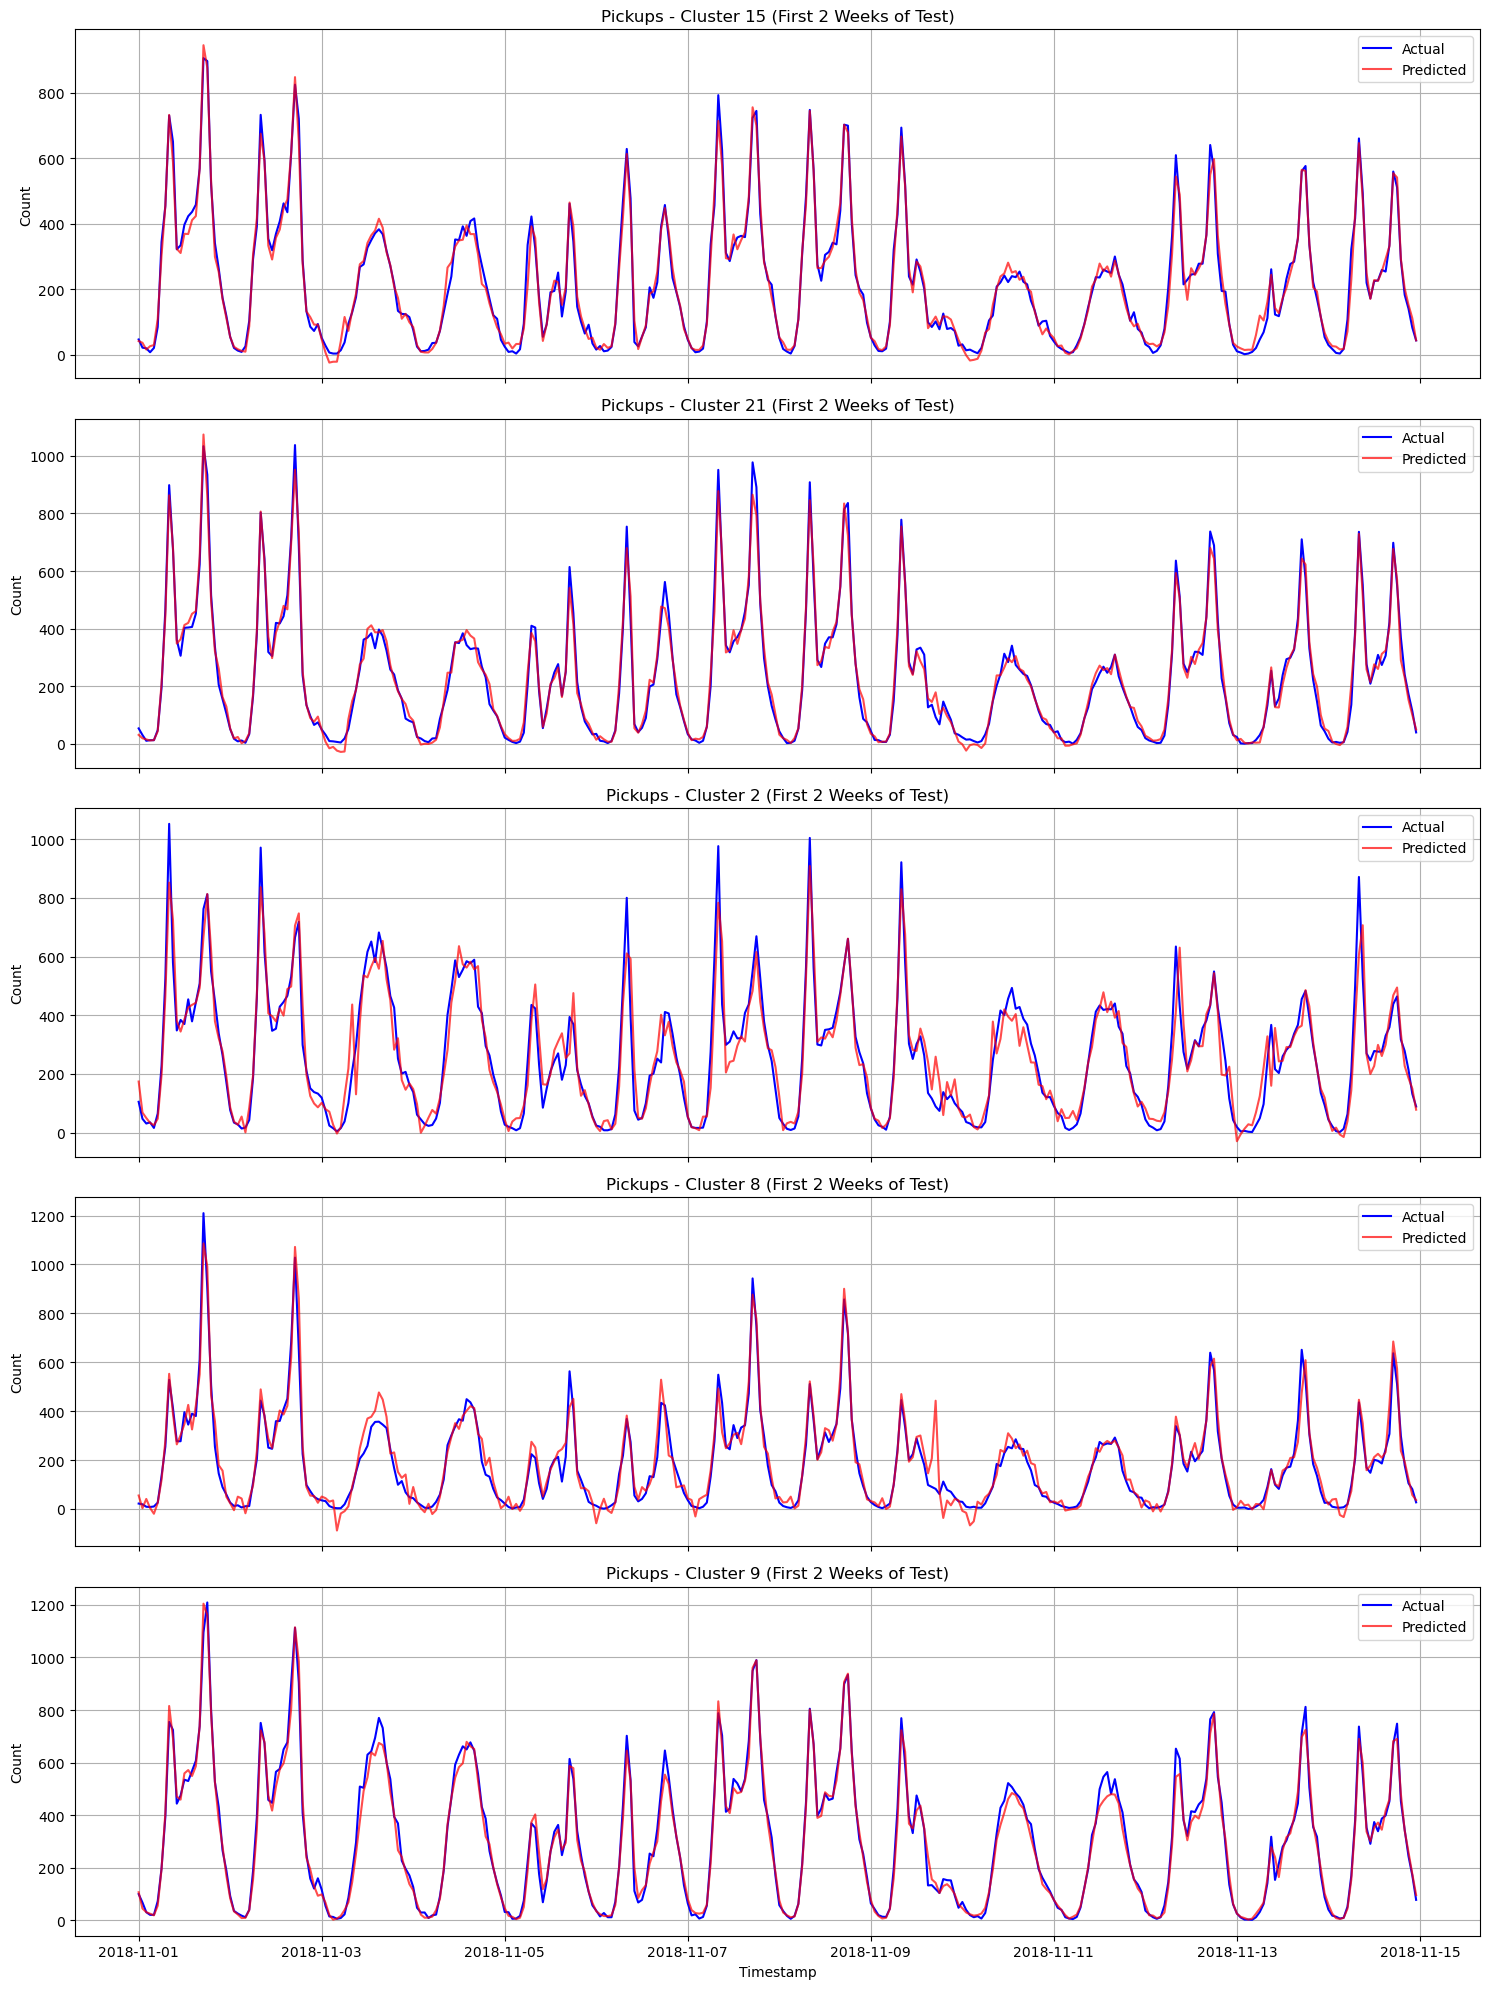

In [148]:
# Plot predictions vs actuals for the first two weeks of the test set for all clusters

# Define time range: first two weeks of the test set
start_date = pickup_test.index.get_level_values('timestamp').min()
end_date = start_date + pd.Timedelta(days=14)

# Filter predictions to this time range
predictions_plot = predictions_test_df.loc[
    (predictions_test_df.index.get_level_values('timestamp') >= start_date) &
    (predictions_test_df.index.get_level_values('timestamp') < end_date)
]

# Plot all clusters in subplots
num_clusters = len(clusters)
fig, axes = plt.subplots(num_clusters, 1, figsize=(15, 4*num_clusters), sharex=True)

for i, cluster in enumerate(clusters):
    # Slice data for this cluster
    df_plot = predictions_plot.xs(cluster, level='start_cluster')
    
    axes[i].plot(df_plot.index, df_plot['y_true'], label='Actual', color='blue')
    axes[i].plot(df_plot.index, df_plot['y_pred'], label='Predicted', color='red', alpha=0.7)
    axes[i].set_title(f'Pickups - Cluster {cluster} (First 2 Weeks of Test)')
    axes[i].set_ylabel('Count')
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()


In [149]:
from sklearn.metrics import r2_score, mean_absolute_error

# Helper function for MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Initialize list to store metrics
metrics_list = []

for cluster in clusters:
    # Slice cluster data
    df_train = pickup_train.xs(cluster, level='start_cluster')
    df_test = pickup_test.xs(cluster, level='start_cluster')
    
    # Get fitted pipeline
    pipeline = pipeline_models[cluster]
    
    # Predict
    y_train_true = df_train['count']
    y_train_pred = pipeline.predict(df_train[feature_cols])
    
    y_test_true = df_test['count']
    y_test_pred = pipeline.predict(df_test[feature_cols])
    
    # Compute metrics
    metrics_list.append({
        'cluster': cluster,
        'r2_train': r2_score(y_train_true, y_train_pred),
        'r2_test': r2_score(y_test_true, y_test_pred),
        'mae_train': mean_absolute_error(y_train_true, y_train_pred),
        'mae_test': mean_absolute_error(y_test_true, y_test_pred),
        'mape_train': mean_absolute_percentage_error(y_train_true, y_train_pred),
        'mape_test': mean_absolute_percentage_error(y_test_true, y_test_pred)
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list).set_index('cluster')

# Show table
metrics_df


r2_train   r2_test  mae_train   mae_test  mape_train   mape_test
cluster                                                                  
15       0.977961  0.974004  22.330001  19.177750   36.543204   42.686686
21       0.982908  0.983840  21.054325  17.343161   38.922637   43.733312
2        0.919669  0.902710  41.538062  38.392616   60.126542   64.119656
8        0.959602  0.933979  29.323137  25.287373   91.422226  101.958527
9        0.987110  0.983411  21.861278  19.147946   22.050421   28.333068

In [151]:
pickup_train.head()

count  hour  Monday  Tuesday  Wednesday  \
timestamp           start_cluster                                            
2018-01-02 09:00:00 15               190     9       0        1          0   
                    21               212     9       0        1          0   
2018-01-02 10:00:00 2                 92    10       0        1          0   
                    8                 40    10       0        1          0   
                    9                100    10       0        1          0   

                                   Thursday  Friday  Saturday  Sunday  \
timestamp           start_cluster                                       
2018-01-02 09:00:00 15                    0       0         0       0   
                    21                    0       0         0       0   
2018-01-02 10:00:00 2                     0       0         0       0   
                    8                     0       0         0       0   
                    9                     0       0         0       0   

                                   count_lag1  ...  count_lag159  \
timestamp           start_cluster              ...                 
2018-01-02 09:00:00 15                  191.0  ...          16.0   
                    21                  190.0  ...          17.0   
2018-01-02 10:00:00 2                   212.0  ...           5.0   
                    8                    92.0  ...          14.0   
                    9                    40.0  ...           7.0   

                                   count_lag160  count_lag161  count_lag162  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     13.0          31.0           7.0   
                    21                     16.0          13.0          31.0   
2018-01-02 10:00:00 2                      17.0          16.0          13.0   
                    8                       5.0          17.0          16.0   
                    9                      14.0           5.0          17.0   

                                   count_lag163  count_lag164  count_lag165  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     32.0          11.0          13.0   
                    21                      7.0          32.0          11.0   
2018-01-02 10:00:00 2                      31.0           7.0          32.0   
                    8                      13.0          31.0           7.0   
                    9                      16.0          13.0          31.0   

                                   count_lag166  count_lag167  count_lag168  
timestamp           start_cluster                                            
2018-01-02 09:00:00 15                     20.0          11.0          16.0  
                    21                     13.0          20.0          11.0  
2018-01-02 10:00:00 2                      11.0          13.0          20.0  
                    8                      32.0          11.0          13.0  
                    9                       7.0          32.0          11.0  

[5 rows x 177 columns]

In [157]:
def my_plot(regr, x, y, size=0.1):

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean absolute error    
    print("Mean Absolute error (MAE): %.2f"% np.mean(abs(regr.predict(x) - y)))
    # The mean squared error
    print("Root Mean squared error: %.2f"
          % np.sqrt(np.mean((regr.predict(x) - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
          
    # Plot outputs
    plt.scatter(y, regr.predict(x), color='blue',linewidth=3)
    plt.plot([0, 1400], [0, 1400], color="red")
    plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
    plt.xlabel("observed")
    plt.ylabel("predicted")
    
    plt.show()

Coefficients: 
 [-1.00876765e-01  4.52609900e+00  0.00000000e+00  0.00000000e+00
  4.23400819e-01 -0.00000000e+00 -4.52387210e+00 -1.71688951e+00
  4.30843999e-01  2.73953806e-01  1.33568506e-01  2.75186064e-02
  6.16394694e-01 -3.23662760e-01 -1.11467135e-01 -1.07872383e-01
 -3.03013240e-02 -1.16515101e-01  4.63077033e-02 -3.31467048e-02
  2.71089612e-02  5.81656208e-02  9.03462784e-02 -1.36376251e-02
 -2.11380477e-02 -2.31048923e-02 -2.44550698e-02  1.93881082e-02
 -1.72581357e-02 -2.28326043e-02 -4.42420682e-03  1.89912489e-02
  3.93289860e-02  5.66493684e-03 -4.21242197e-03 -2.86761639e-02
 -2.15769352e-02  9.78571023e-03  1.58306338e-02 -2.39502911e-02
  1.29036416e-02  6.71842901e-03 -3.75723673e-02 -2.87643483e-02
  5.20592445e-02  1.26757551e-02  3.62057650e-03 -8.59082103e-03
 -6.25479585e-02  3.54223454e-02  2.69786849e-02  2.09745358e-02
  6.35222076e-02  1.18170852e-01 -1.34420066e-01 -1.14699552e-02
  1.83891096e-02 -4.79997454e-02 -6.15272458e-02  4.49057799e-02
 -1.32208

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e+07, tolerance: 2.070e+05
  model = cd_fast.enet_coordinate_descent(


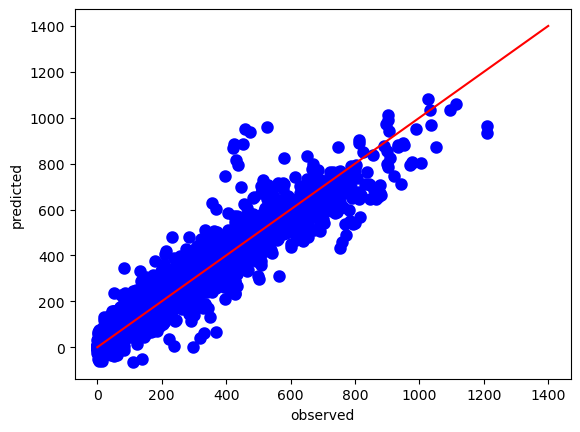

In [ ]:
# Let's fit a Lasso regression model on pickups to predict bike_count 
from sklearn.linear_model import Lasso


lasso_pickup = Lasso(alpha=0.1)
lasso_pickup.fit(
    pickup_train.drop(columns=["count"]),
    pickup_train["count"]
)
# Now let's evaluate the model on the test set
my_plot(
    lasso_pickup,
    pickup_test.drop(columns=["count"]),
    pickup_test["count"]
)


=== Cluster 15 ===
Coefficients: 
 [ 2.14581750e-01  1.23278296e+00  6.21468653e-01  0.00000000e+00
  0.00000000e+00 -1.00010738e+00 -2.70908913e+01 -1.82425867e+01
  3.54781899e-01  2.84950128e-01  2.12721531e-01  8.36146157e-02
  4.66521791e-01 -2.15288761e-01 -1.71819551e-01 -4.19240288e-02
 -2.15140441e-02  3.85103532e-02 -3.06625995e-02 -2.29172107e-02
 -7.30856420e-02  1.24759388e-02  3.23929089e-02  2.18771196e-03
 -2.20363768e-02  1.30738735e-02 -1.15451652e-02 -9.45797435e-03
  6.26508878e-03  5.09670634e-03 -1.38915357e-02 -2.95864277e-02
  3.71769265e-02 -1.44288560e-02  3.86178862e-02  7.34952916e-03
 -6.86206242e-03  2.34983284e-02 -4.24286319e-02  1.23091153e-02
  2.48733234e-02 -3.38167000e-02  2.29927303e-03  5.96832358e-03
  6.90533196e-03  1.53733395e-02  7.92291439e-03  1.69075350e-02
  1.31255689e-02 -2.70912758e-02 -1.42753530e-02  2.37629583e-02
 -8.40350612e-04 -1.91465644e-03 -3.98774083e-02  4.57476080e-02
 -1.10010533e-02  1.35687637e-03 -1.36150588e-02 -9.82

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.826e+06, tolerance: 3.191e+04
  model = cd_fast.enet_coordinate_descent(


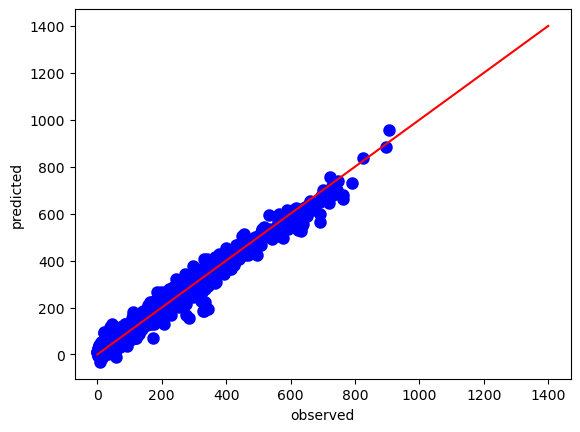


=== Cluster 21 ===
Coefficients: 
 [ 1.14050978e-01  2.34011704e+00  1.79346863e-01  0.00000000e+00
  0.00000000e+00 -2.02350195e+00 -5.61423262e+00 -6.42948319e+00
  3.67562203e-01  1.70302195e-01  2.85840208e-01  2.25760219e-01
  4.71065091e-01  2.20754198e-02 -1.80375068e-01 -3.28465102e-01
 -3.36453827e-02  7.03264880e-02  6.97984722e-02 -4.09694219e-02
 -8.70045039e-02 -5.66037897e-02  2.57022519e-02 -1.67809110e-02
 -5.48502938e-03  4.78258430e-02 -3.05712167e-02  1.67984559e-02
 -3.74404408e-02 -1.40719635e-03  2.08301695e-02  1.99059096e-02
  4.84644453e-03  4.73081909e-02 -3.26694663e-02  6.52945360e-03
 -8.40954256e-04  2.86525461e-03  8.22048005e-03 -8.82844580e-03
 -5.65425684e-03  2.77902581e-02 -3.01460097e-03  2.38429136e-02
 -8.80175493e-03  3.09981289e-03 -7.84887908e-03  4.32352630e-03
  2.79918273e-02 -1.53214621e-02 -1.02876184e-02  8.48880750e-03
  3.09871117e-02 -6.77294254e-03 -4.87053034e-02 -2.40939203e-02
  9.71196340e-02 -1.88488655e-03  4.56712194e-02 -3.29

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.598e+06, tolerance: 3.891e+04
  model = cd_fast.enet_coordinate_descent(


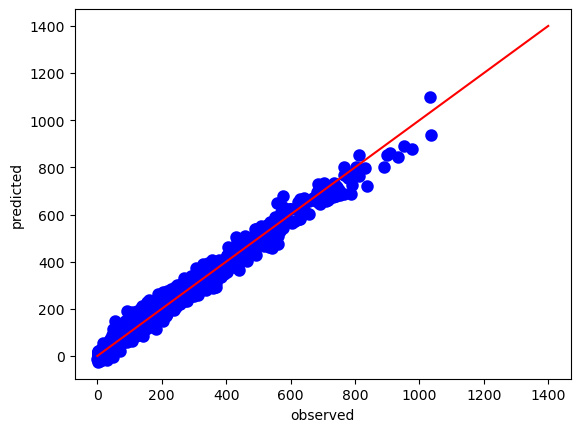


=== Cluster 2 ===
Coefficients: 
 [ 9.67150764e-01 -5.30253903e+00  3.04867813e+00  0.00000000e+00
  5.64449277e+00  2.03562164e+00 -7.51834264e+00 -2.13145627e+01
 -2.58161372e-01  4.25429529e-01  2.95144862e-01  6.87663746e-02
  5.72895276e-01 -4.82293774e-01  3.46357803e-01  6.76664526e-02
 -9.54208408e-02 -1.71892691e-01  2.19970198e-01 -4.61167145e-01
  1.32749120e-01 -3.24555125e-02  2.78330819e-02  8.05204447e-02
 -1.46716989e-01 -4.00681230e-02  4.09793221e-02  4.58096054e-02
 -2.84068743e-02  5.45225570e-04  2.54635229e-02  1.36599003e-02
 -4.22058315e-02 -1.33047664e-02  6.29261236e-02 -7.56297400e-02
  2.77398189e-02 -3.53503322e-02 -3.66803783e-03  5.21266205e-03
 -2.77838012e-02  4.85191248e-02 -2.14697058e-02  2.27155647e-02
  6.45703479e-02 -1.91730735e-02 -1.34450966e-02 -7.54893189e-02
  3.67669008e-02  2.28118507e-02  4.34415267e-03 -5.87130417e-02
  1.02458415e-01 -3.58683580e-03 -6.43766553e-02  5.60145604e-03
 -4.53242578e-02  1.37109372e-01 -5.73564075e-02  1.854

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+07, tolerance: 3.611e+04
  model = cd_fast.enet_coordinate_descent(


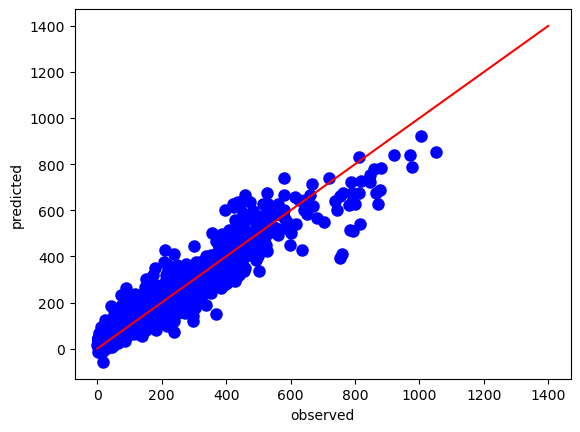


=== Cluster 8 ===
Coefficients: 
 [-8.48377248e-01  3.56398992e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.56606245e-01  0.00000000e+00 -2.24745001e-01
  5.35072802e-01  1.41216444e-01  2.05403708e-02  8.77611264e-03
  6.23760401e-01 -3.09631696e-01 -9.64988398e-02 -1.19480978e-01
  7.81119548e-02 -1.30369605e-01  2.54678398e-02  8.43217060e-02
  6.27851515e-02 -2.83641608e-02  1.59535803e-02 -1.29429806e-02
 -2.33412337e-02 -1.00760487e-02 -1.27467479e-02  1.49755970e-02
  1.87212190e-02 -1.46635928e-03  4.72764004e-02  1.73403166e-02
  1.32560281e-02 -2.17721202e-02 -2.65110126e-02  2.68965839e-03
 -3.05128883e-02  1.09281312e-02  6.80251195e-03 -2.88936020e-02
  1.95742539e-02 -2.52995139e-02  9.48528497e-03 -4.81632982e-02
  9.56026825e-02  1.66575158e-01  3.13952899e-03 -1.14120601e-01
 -1.68189262e-01  1.97930658e-01  1.51326451e-03 -6.09700326e-02
 -1.14603863e-01  3.93753751e-01 -2.14293276e-02 -1.33845289e-01
 -3.02530702e-02  1.38630788e-02 -7.87157965e-02 -1.201

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.617e+06, tolerance: 3.759e+04
  model = cd_fast.enet_coordinate_descent(


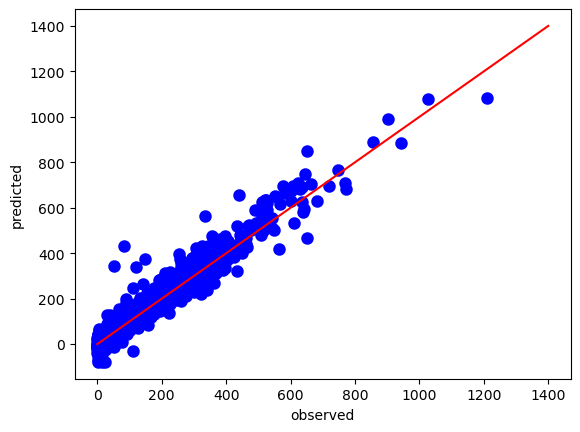


=== Cluster 9 ===
Coefficients: 
 [ 8.49214600e-02  2.18023116e-01 -0.00000000e+00  1.66837510e+00
 -7.98281192e-01 -3.85693745e+00  1.46960606e+00 -0.00000000e+00
  5.51671915e-01  3.93281258e-01  8.24206487e-02  1.03564457e-01
  2.87398259e-01 -4.33315071e-02 -5.91184419e-02 -5.55715045e-02
 -5.87970929e-02  9.35988534e-02 -9.04381504e-02 -6.55319151e-02
  1.15965090e-02  3.40965957e-02  8.91361309e-03  1.43241466e-02
  1.82375691e-02  6.87756889e-02 -5.77302259e-02  1.55713999e-02
 -5.14952133e-02 -1.82142685e-02  2.41348190e-02  6.19995817e-03
 -2.25101147e-02 -5.48574391e-03  1.36971764e-02 -9.44327578e-03
  2.50121738e-02 -8.72390867e-03 -1.13401456e-02 -3.54096677e-03
  2.08179122e-02  2.88353032e-03  6.18370794e-03 -1.48425661e-03
 -5.43348663e-03 -2.14966407e-02  1.55582257e-03  1.34962656e-02
 -2.09423123e-02  1.16901772e-02 -1.93770558e-03  2.44923589e-02
 -7.25854518e-03 -1.34176223e-03 -6.37343093e-03 -6.42013337e-03
  1.38182609e-02 -2.24639228e-02 -6.44978133e-06  2.111

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.958e+06, tolerance: 5.754e+04
  model = cd_fast.enet_coordinate_descent(


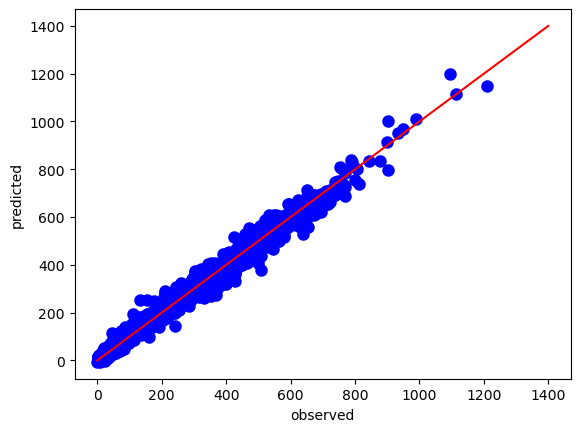

In [166]:
# Let's do this for each cluster separately

clusters = pickup_train.index.get_level_values("start_cluster").unique()

lasso_models = {}   # store models if you want them later

for cluster in clusters:
    # Extract this cluster’s training data
    X_train = pickup_train.xs(cluster, level="start_cluster").drop(columns=["count"])
    y_train = pickup_train.xs(cluster, level="start_cluster")["count"]

    # Extract this cluster’s test data
    X_test  = pickup_test.xs(cluster, level="start_cluster").drop(columns=["count"])
    y_test  = pickup_test.xs(cluster, level="start_cluster")["count"]

    # Fit Lasso model
    #model = Lasso(alpha=0.1)
    lasso_pickup.fit(X_train, y_train)

    # Store model (optional)
    lasso_models[cluster] = lasso_pickup

    # Plot results for this cluster
    print(f"\n=== Cluster {cluster} ===")
    my_plot(
        lasso_pickup,
        X_test,
        y_test
    )

In [161]:
def plotprediction(series, pred_series, metrics, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    plt.legend(loc="upper right")
    plt.grid(True)
    
    ax = plt.gca()
    ax.text(0.01, 0.95, "\n".join(metrics),
            transform=ax.transAxes, ha="left", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.75))
    plt.tight_layout()
    # Plot confidence intervals for smoothed values
    plt.show()

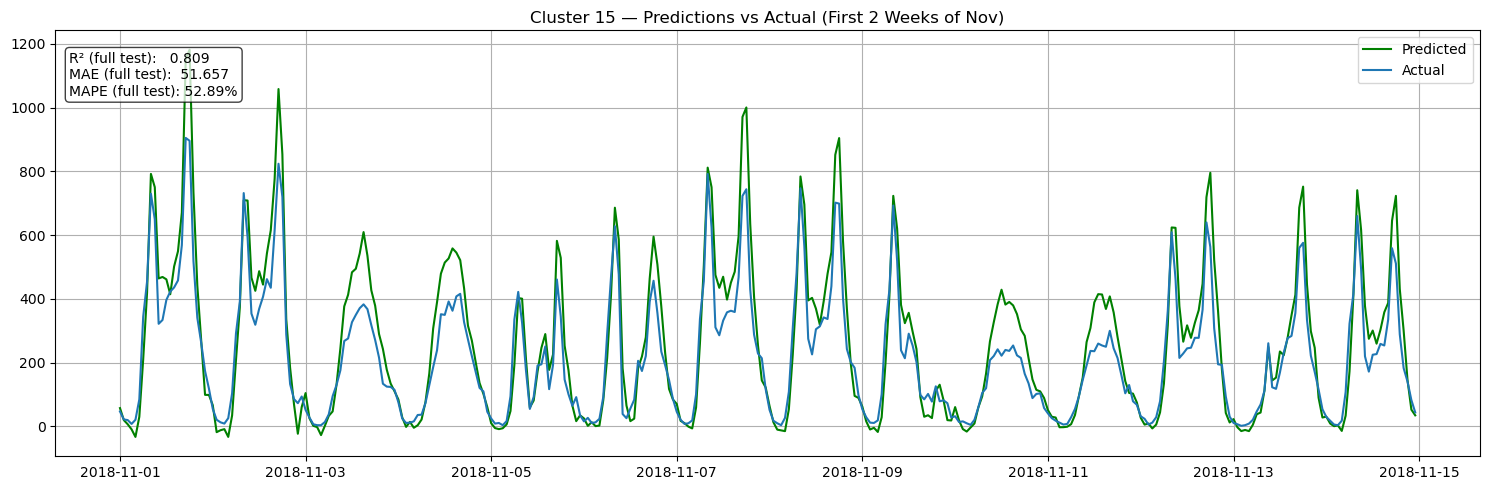

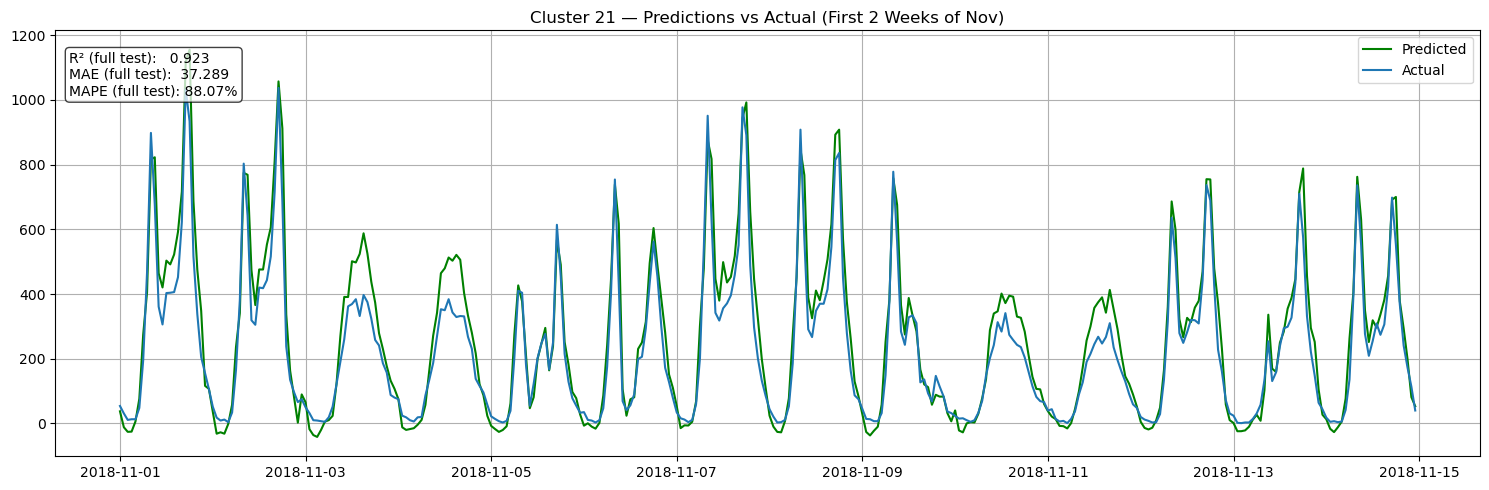

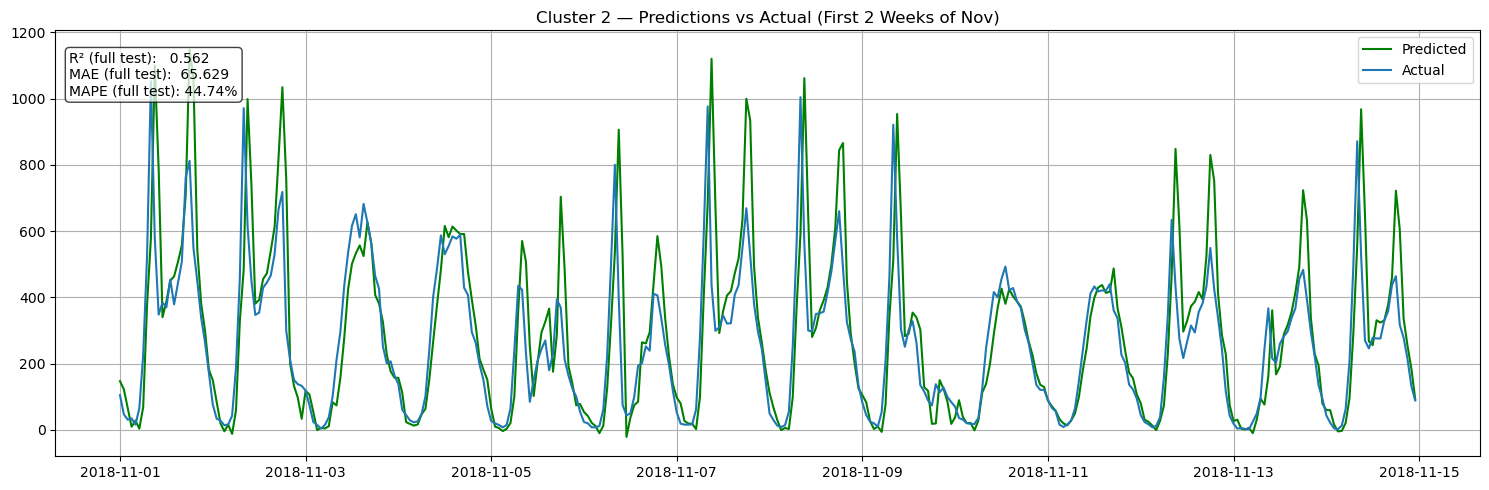

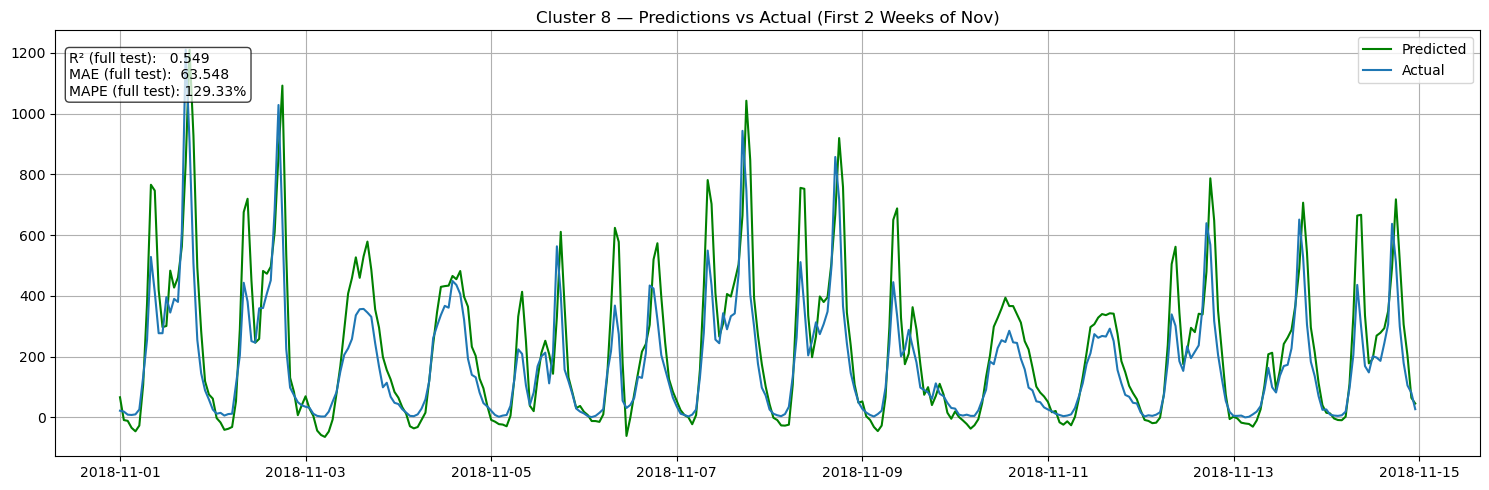

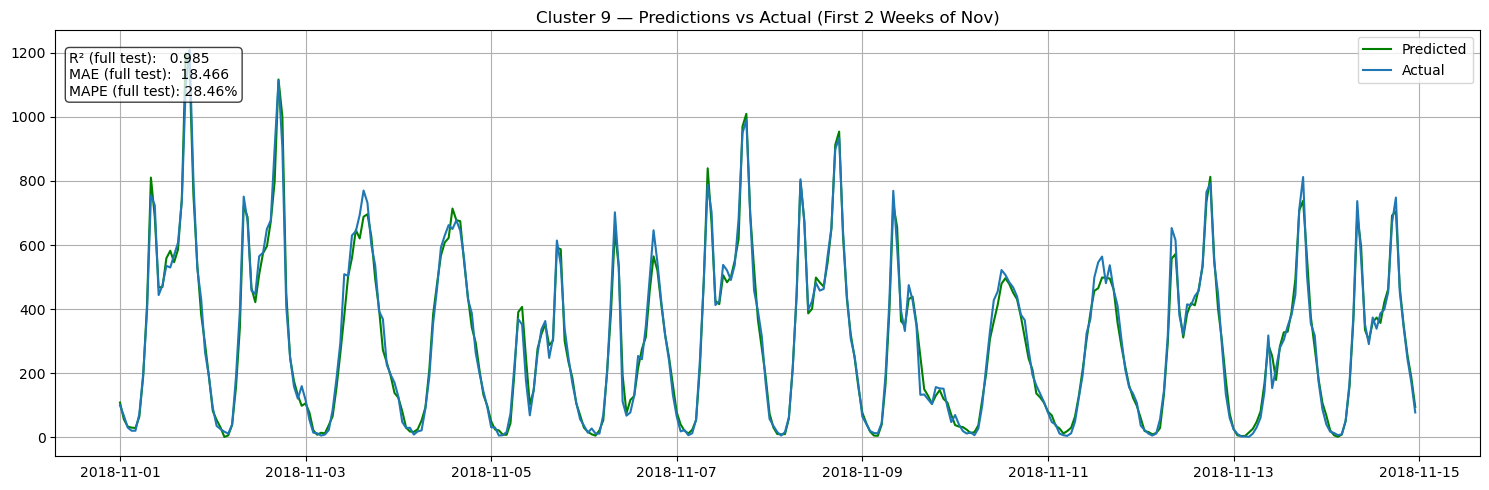

In [167]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# MAPE helper
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# ------------------------------------------------------
# 1) Time window for first two weeks of November test set
# ------------------------------------------------------
start_date = pd.Timestamp("2018-11-01 00:00:00")
end_date   = start_date + pd.Timedelta(days=14)


# ------------------------------------------------------
# 2) Loop through clusters and plot
# ------------------------------------------------------
for cluster in clusters:

    # Entire test set for this cluster
    X_test_full = pickup_test.xs(cluster, level="start_cluster").drop(columns=["count"])
    y_test_full = pickup_test.xs(cluster, level="start_cluster")["count"]

    # Predict on the entire test set
    model = lasso_models[cluster]
    y_pred_full = model.predict(X_test_full)

    # ---------------------------
    # Full test-set metrics
    # ---------------------------
    r2  = r2_score(y_test_full, y_pred_full)
    mae = mean_absolute_error(y_test_full, y_pred_full)
    mape_val = mape(y_test_full, y_pred_full)

    metrics = [
        f"R² (full test):   {r2:.3f}",
        f"MAE (full test):  {mae:.3f}",
        f"MAPE (full test): {mape_val:.2f}%"
    ]

    # ---------------------------
    # First 2 weeks subset for plotting
    # ---------------------------
    mask = (X_test_full.index >= start_date) & (X_test_full.index < end_date)
    
    y_plot = y_test_full.loc[mask]
    y_pred_plot = pd.Series(y_pred_full, index=y_test_full.index).loc[mask]

    # ---------------------------
    # Plot only the 2-week period
    # ---------------------------
    plotprediction(
        series=y_plot,
        pred_series=y_pred_plot,
        metrics=metrics,                # <-- full test metrics
        labels=["Actual", "Predicted"],
        x_axis=y_plot.index,
        title=f"Cluster {cluster} — Predictions vs Actual (First 2 Weeks of Nov)"
    )


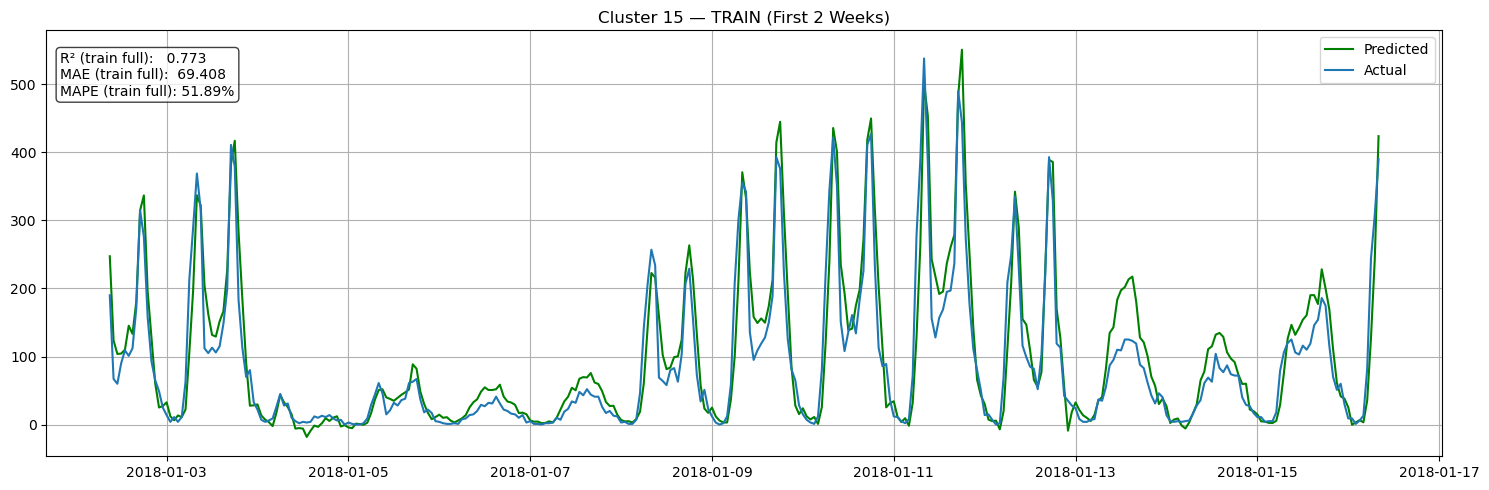

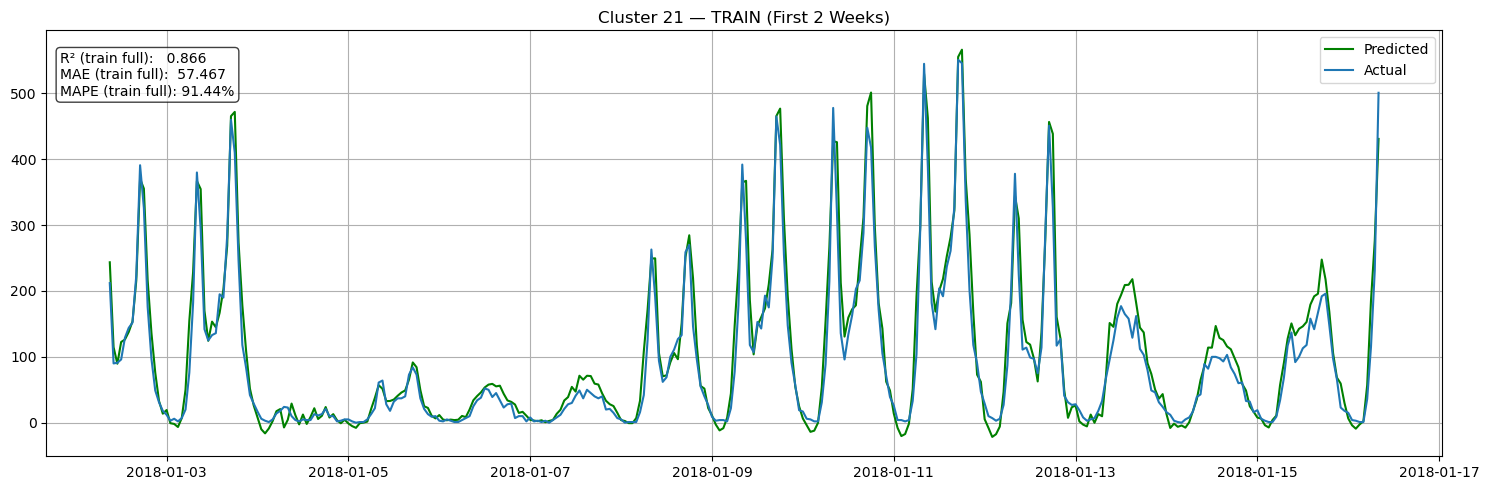

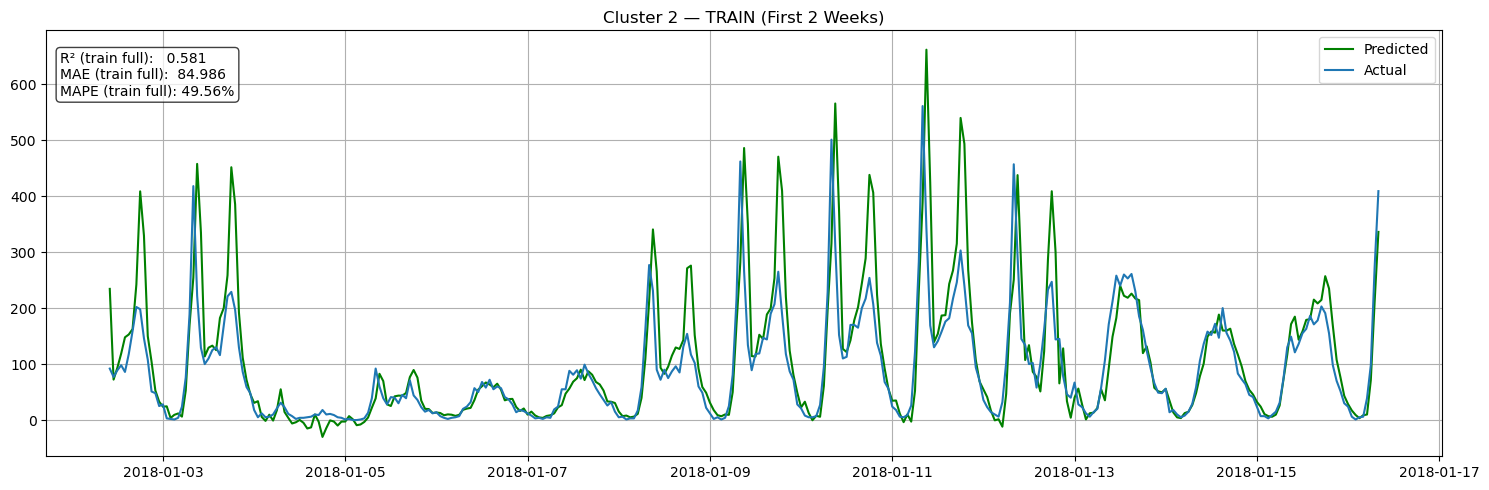

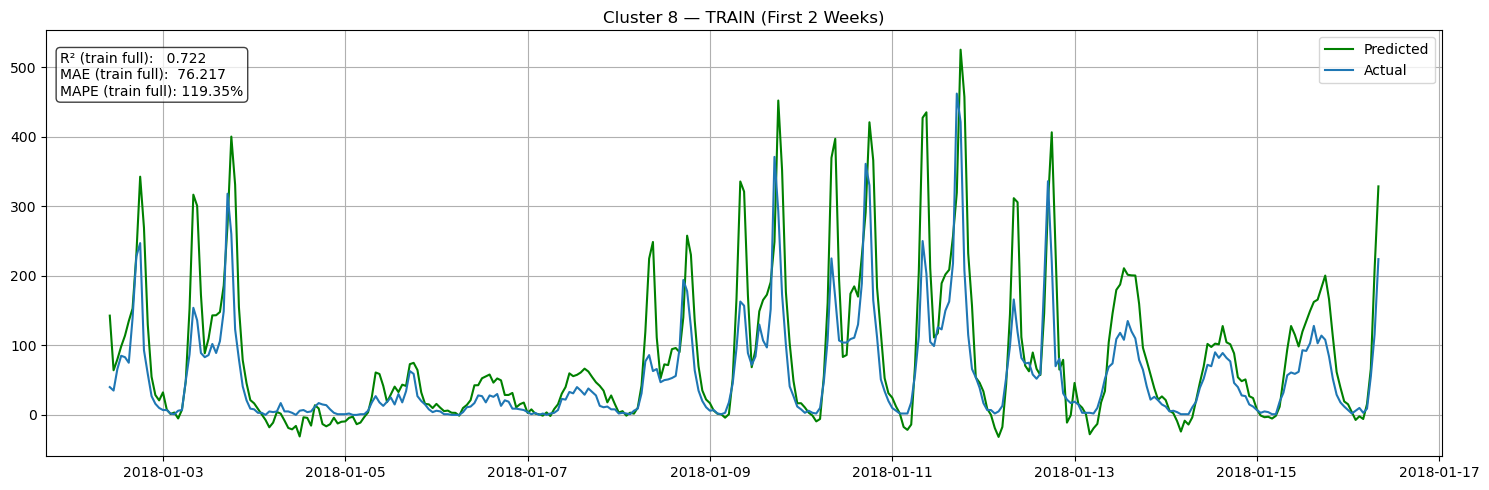

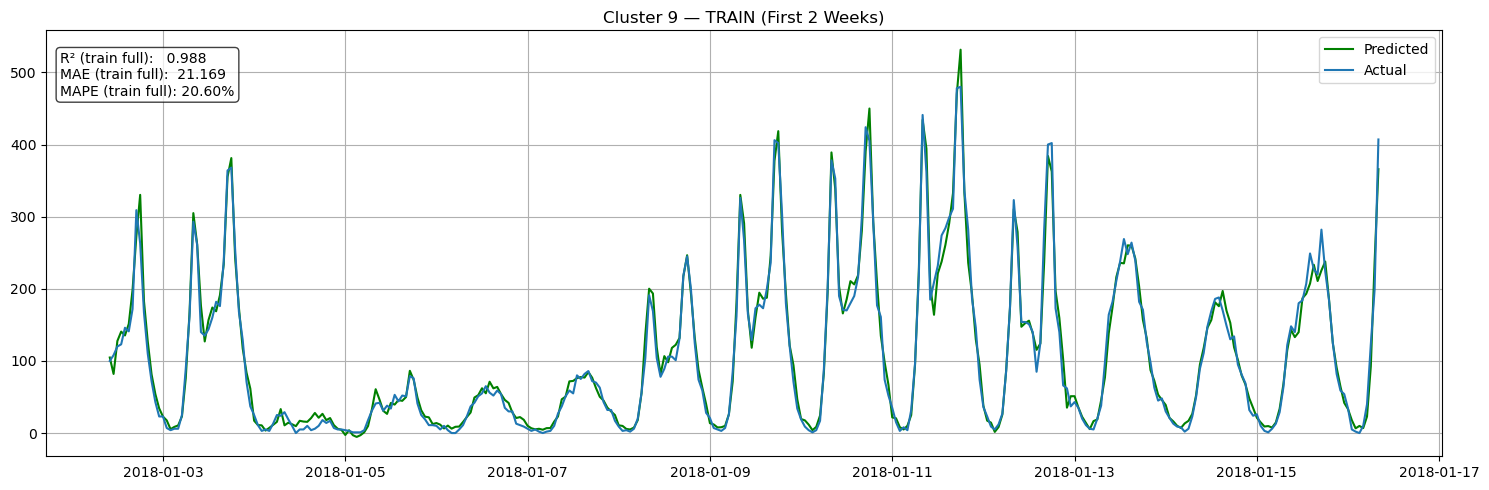

In [168]:
# The same but for the train set



# ------------------------------------------------------
# 1) Time window: first two weeks of the TRAIN set
# ------------------------------------------------------
train_start_date = pickup_train.index.get_level_values("timestamp").min()
train_end_date   = train_start_date + pd.Timedelta(days=14)


# ------------------------------------------------------
# 2) Loop through clusters — TRAIN reference plots
# ------------------------------------------------------
for cluster in clusters:

    # Entire TRAIN set for this cluster
    X_train_full = pickup_train.xs(cluster, level="start_cluster").drop(columns=["count"])
    y_train_full = pickup_train.xs(cluster, level="start_cluster")["count"]

    # Predict on entire TRAIN set
    model = lasso_models[cluster]
    y_pred_train_full = model.predict(X_train_full)

    # ---------------------------
    # Full train-set metrics
    # ---------------------------
    r2_train  = r2_score(y_train_full, y_pred_train_full)
    mae_train = mean_absolute_error(y_train_full, y_pred_train_full)
    mape_train = mape(y_train_full, y_pred_train_full)

    metrics = [
        f"R² (train full):   {r2_train:.3f}",
        f"MAE (train full):  {mae_train:.3f}",
        f"MAPE (train full): {mape_train:.2f}%"
    ]

    # ---------------------------
    # First 2 weeks subset for plotting
    # ---------------------------
    mask = (X_train_full.index >= train_start_date) & (X_train_full.index < train_end_date)

    y_plot = y_train_full.loc[mask]
    y_pred_plot = pd.Series(y_pred_train_full, index=y_train_full.index).loc[mask]

    # ---------------------------
    # Plot only the 2-week period
    # ---------------------------
    plotprediction(
        series=y_plot,
        pred_series=y_pred_plot,
        metrics=metrics,       # <-- full train metrics added
        labels=["Actual", "Predicted"],
        x_axis=y_plot.index,
        title=f"Cluster {cluster} — TRAIN (First 2 Weeks)"
    )


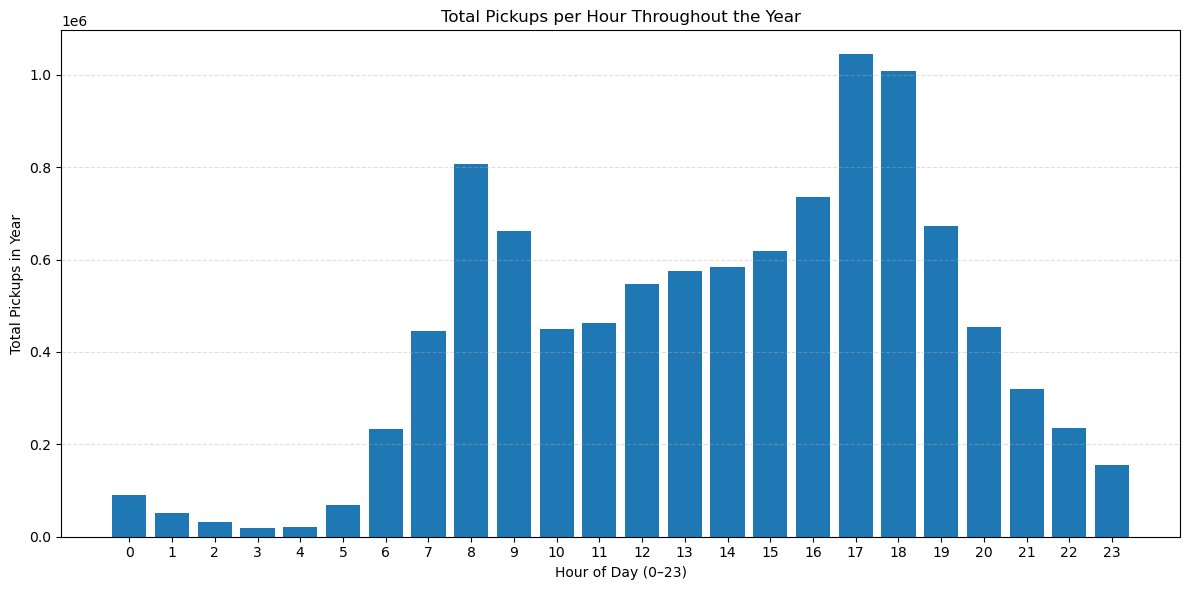

In [ ]:
# # Now let's plot the total pickup for each hour througout the year for the chosen clusters
# # create an hour column
# f['hour'] = f['starttime'].dt.hour

# # --- Compute total pickups per hour ---
# hourly_counts = f.groupby('hour').size()

# # Ensure all 24 hours exist
# hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# # --- Plot ---
# plt.figure(figsize=(12,6))
# plt.bar(hourly_counts.index, hourly_counts.values)
# plt.xlabel("Hour of Day (0–23)")
# plt.ylabel("Total Pickups in Year")
# plt.title("Total Pickups per Hour Throughout the Year")
# plt.xticks(range(24))
# plt.grid(axis='y', linestyle='--', alpha=0.4)
# plt.tight_layout()
# plt.show()

In [61]:
# # --- Assumptions ---

# # Station id column:
# station_col = f['start_station_id']  # adjust if different

# # --- Build day & hour keys ---
# f['day']  = f['starttime'].dt.day    # midnight-normalized dates (YYYY-MM-DD as Timestamp)
# f['hour'] = f['starttime'].dt.hour            # 0..23

# # --- Group by cluster/day/hour and pivot to day x hour ---
# grp = f.groupby(['cluster', 'day', 'hour']).size()

# # Make sure all 24 hours exist in every pivot
# def pivot_cluster(g):
#     df = (g.unstack('hour', fill_value=0)
#             .reindex(columns=range(24), fill_value=0))
#     return df

# cluster_pivot = grp.groupby(level='cluster', group_keys=False).apply(pivot_cluster)

# # --- Ensure all days in your year appear, even if zeros (nice for modeling) ---
# date_min = f['day'].min()
# date_max = f['day'].max()
# all_days = pd.date_range(date_min, date_max, freq='D')

# def reindex_days(df):
#     return df.reindex(all_days, fill_value=0)

# #cluster_pivot = cluster_pivot.groupby(level='cluster', group_keys=True)\
# #                             .apply(reindex_days)

# # Now `cluster_pivot` has a MultiIndex row (cluster, day) and columns 0..23.
# # If you prefer separate tables per cluster:
# cluster_tables = {
#     c: cluster_pivot.xs(c, level='cluster').rename_axis('day')
#     for c in cluster_pivot.index.get_level_values('cluster').unique()
# }

# # change the number to see for each cluster
# cluster_tables[8]



In [ ]:
# Drop columns 
f.drop(columns=['bikeid', 'gender', 'birth_year', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'usertype'], axis=1, inplace=True)

# Add column to 'f' representing day of the week
f['day_of_week'] = f['starttime'].dt.dayofweek

In [ ]:
# Make new dataframe with bike counts per hour

f["starttime"] = pd.to_datetime(f["starttime"])

f["hour_start"] = f["starttime"].dt.floor("H")

hourly = (
    f.groupby("hour_start")
      .size()
      .reset_index(name="bike_count")
)

hourly["hour_of_day"] = hourly["hour_start"].dt.hour
hourly["weekday"] = hourly["hour_start"].dt.dayofweek

hourly

/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/351790435.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f["hour_start"] = f["starttime"].dt.floor("H")


hour_start  bike_count  hour_of_day  weekday
0    2018-01-01 00:00:00          71            0        0
1    2018-01-01 01:00:00          99            1        0
2    2018-01-01 02:00:00          51            2        0
3    2018-01-01 03:00:00          41            3        0
4    2018-01-01 04:00:00          18            4        0
...                  ...         ...          ...      ...
8737 2018-12-31 19:00:00          91           19        0
8738 2018-12-31 20:00:00         115           20        0
8739 2018-12-31 21:00:00          48           21        0
8740 2018-12-31 22:00:00          54           22        0
8741 2018-12-31 23:00:00          35           23        0

[8742 rows x 4 columns]

In [23]:
# create weekday dummy variables
hourly_with_dummies = pd.get_dummies(
    hourly,
    columns=["weekday"],
    prefix="wd",
    dtype=int
)

In [24]:
hourly_with_dummies.head()

hour_start  bike_count  hour_of_day  wd_0  wd_1  wd_2  wd_3  wd_4  \
0 2018-01-01 00:00:00          71            0     1     0     0     0     0   
1 2018-01-01 01:00:00          99            1     1     0     0     0     0   
2 2018-01-01 02:00:00          51            2     1     0     0     0     0   
3 2018-01-01 03:00:00          41            3     1     0     0     0     0   
4 2018-01-01 04:00:00          18            4     1     0     0     0     0   

   wd_5  wd_6  
0     0     0  
1     0     0  
2     0     0  
3     0     0  
4     0     0

In [25]:
weekday_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

# build a rename dictionary for the dummy columns
rename_dict = {f"weekday_{k}": v for k, v in weekday_names.items()}

# apply renaming (works with your dummies, whatever their prefix)
hourly_with_dummies = hourly_with_dummies.rename(columns=rename_dict)

In [ ]:
# Change names of the dummy columns to actual weekday names 
weekday_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

rename_dict = {f"wd_{k}": v for k, v in weekday_names.items()}

hourly_with_dummies = hourly_with_dummies.rename(columns=rename_dict)

hourly_with_dummies.head()

hour_start  bike_count  hour_of_day  Monday  Tuesday  Wednesday  \
0 2018-01-01 00:00:00          71            0       1        0          0   
1 2018-01-01 01:00:00          99            1       1        0          0   
2 2018-01-01 02:00:00          51            2       1        0          0   
3 2018-01-01 03:00:00          41            3       1        0          0   
4 2018-01-01 04:00:00          18            4       1        0          0   

   Thursday  Friday  Saturday  Sunday  
0         0       0         0       0  
1         0       0         0       0  
2         0       0         0       0  
3         0       0         0       0  
4         0       0         0       0

In [ ]:
# define cutoff
cutoff = pd.Timestamp("2018-11-01")

# train: start → end of October 2018
X_train = hourly_with_dummies[hourly_with_dummies["hour_start"] < cutoff]

# test: November 1st 2018 → end
X_test = hourly_with_dummies[hourly_with_dummies["hour_start"] >= cutoff]

In [35]:
# Let's build lagged features for bike_count with a lag of 168 hours (1 week)
hourly_lagged = buildLaggedFeatures(hourly_with_dummies, columns=["bike_count"], lag=168, dropna=True)
hourly_lagged.head()

hour_start  bike_count  hour_of_day  Monday  Tuesday  Wednesday  \
168 2018-01-08 00:00:00          24            0       1        0          0   
169 2018-01-08 01:00:00          16            1       1        0          0   
170 2018-01-08 02:00:00           9            2       1        0          0   
171 2018-01-08 03:00:00           8            3       1        0          0   
172 2018-01-08 04:00:00          23            4       1        0          0   

     Thursday  Friday  Saturday  Sunday  ...  bike_count_lag159  \
168         0       0         0       0  ...               80.0   
169         0       0         0       0  ...              122.0   
170         0       0         0       0  ...              200.0   
171         0       0         0       0  ...              209.0   
172         0       0         0       0  ...              255.0   

     bike_count_lag160  bike_count_lag161  bike_count_lag162  \
168               61.0               44.0               24.0   
169               80.0               61.0               44.0   
170              122.0               80.0               61.0   
171              200.0              122.0               80.0   
172              209.0              200.0              122.0   

     bike_count_lag163  bike_count_lag164  bike_count_lag165  \
168               19.0               18.0               41.0   
169               24.0               19.0               18.0   
170               44.0               24.0               19.0   
171               61.0               44.0               24.0   
172               80.0               61.0               44.0   

     bike_count_lag166  bike_count_lag167  bike_count_lag168  
168               51.0               99.0               71.0  
169               41.0               51.0               99.0  
170               18.0               41.0               51.0  
171               19.0               18.0               41.0  
172               24.0               19.0               18.0  

[5 rows x 178 columns]

In [40]:
hourly_lagged.head()

hour_start  bike_count  hour_of_day  Monday  Tuesday  Wednesday  \
168 2018-01-08 00:00:00          24            0       1        0          0   
169 2018-01-08 01:00:00          16            1       1        0          0   
170 2018-01-08 02:00:00           9            2       1        0          0   
171 2018-01-08 03:00:00           8            3       1        0          0   
172 2018-01-08 04:00:00          23            4       1        0          0   

     Thursday  Friday  Saturday  Sunday  ...  bike_count_lag159  \
168         0       0         0       0  ...               80.0   
169         0       0         0       0  ...              122.0   
170         0       0         0       0  ...              200.0   
171         0       0         0       0  ...              209.0   
172         0       0         0       0  ...              255.0   

     bike_count_lag160  bike_count_lag161  bike_count_lag162  \
168               61.0               44.0               24.0   
169               80.0               61.0               44.0   
170              122.0               80.0               61.0   
171              200.0              122.0               80.0   
172              209.0              200.0              122.0   

     bike_count_lag163  bike_count_lag164  bike_count_lag165  \
168               19.0               18.0               41.0   
169               24.0               19.0               18.0   
170               44.0               24.0               19.0   
171               61.0               44.0               24.0   
172               80.0               61.0               44.0   

     bike_count_lag166  bike_count_lag167  bike_count_lag168  
168               51.0               99.0               71.0  
169               41.0               51.0               99.0  
170               18.0               41.0               51.0  
171               19.0               18.0               41.0  
172               24.0               19.0               18.0  

[5 rows x 178 columns]

In [41]:
# define cutoff
cutoff = pd.Timestamp("2018-11-01")

# train: start → end of October 2018
X_train = hourly_lagged[hourly_lagged["hour_start"] < cutoff]

# test: November 1st 2018 → end
X_test = hourly_lagged[hourly_lagged["hour_start"] >= cutoff]

Coefficients: 
 [-3.05295588e+00  1.56627396e+01  1.76054089e+01  2.55578374e+00
 -0.00000000e+00 -2.74222783e+00 -5.58127524e+01 -6.69907660e+01
  1.11551368e+00 -5.08644199e-01  1.85819153e-01 -5.48310014e-02
  3.80542438e-02 -2.29022946e-02 -2.11758114e-02 -4.00055301e-02
  2.43060667e-01 -1.29682503e-01 -3.04531625e-02  7.68819025e-02
 -1.21315149e-01  1.03090206e-01 -4.72396780e-02 -3.41062491e-03
  3.96504501e-02 -5.42733029e-02  8.77066422e-03  3.74892688e-02
 -5.87080812e-02  7.09829777e-02 -3.82895156e-02  3.75920478e-01
 -4.08305167e-01  1.12728556e-01  2.10436800e-03  1.47107240e-03
 -3.68274807e-02  4.25012216e-02  6.26460162e-03 -4.79074393e-02
 -2.17484830e-02  4.39498931e-04  3.17389448e-02 -2.83810354e-02
  2.81588595e-02 -1.22067981e-02 -3.15869538e-02  2.53258941e-02
  2.57404765e-02 -1.57732811e-02 -4.00075719e-05  7.76955347e-03
  9.56178523e-03 -1.13362793e-03 -3.71772965e-02  3.67550517e-02
 -3.71302450e-02  5.82660094e-02 -2.42852419e-02  1.49686248e-02
  1.44322

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e+08, tolerance: 9.216e+05
  model = cd_fast.enet_coordinate_descent(


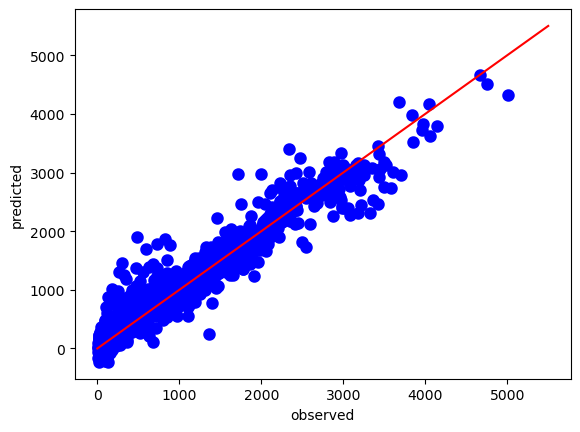

In [ ]:
# Let's fit a Lasso regression model on X_train to predict bike_count 
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(
    X_train.drop(columns=["hour_start", "bike_count"]),
    X_train["bike_count"]
)
# Now let's evaluate the model on the test set
my_plot(
    lasso,
    X_test.drop(columns=["hour_start", "bike_count"]),
    X_test["bike_count"]
)

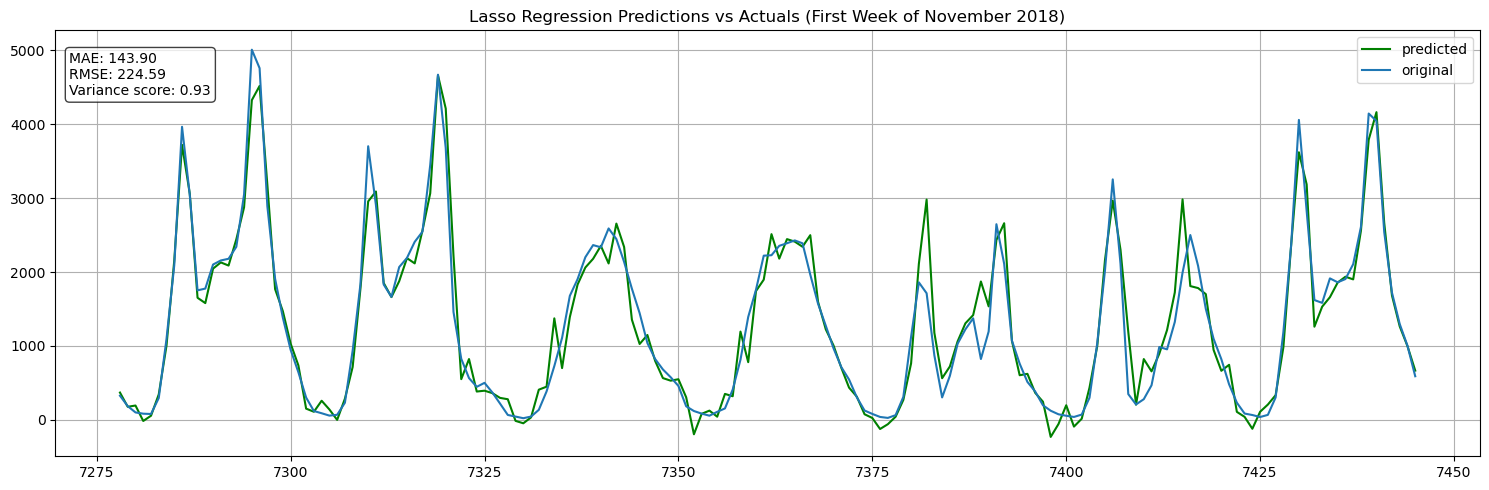

In [49]:
# Plot predictions vs actuals, but only for first week of November for clarity
plotprediction(
    series=X_test["bike_count"].iloc[:24*7],
    pred_series=pd.Series(
        lasso.predict(
            X_test.drop(columns=["hour_start", "bike_count"])
        ),
        index=X_test.index
    ).iloc[:24*7],
    metrics=[
        f"MAE: {np.mean(abs(lasso.predict(X_test.drop(columns=['hour_start', 'bike_count'])) - X_test['bike_count'])):.2f}",
        f"RMSE: {np.sqrt(np.mean((lasso.predict(X_test.drop(columns=['hour_start', 'bike_count'])) - X_test['bike_count']) ** 2)):.2f}",
        f"Variance score: {lasso.score(X_test.drop(columns=['hour_start', 'bike_count']), X_test['bike_count']):.2f}"
    ],
    title="Lasso Regression Predictions vs Actuals (First Week of November 2018)"
)


-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-


In [169]:
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00


In [170]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# Dictionary to store models and predictions
lgb_models = {}
lgb_predictions_test = {}
lgb_predictions_train = {}
lgb_metrics = {}

clusters = sorted(pickup_train.index.get_level_values("start_cluster").unique())

feature_cols = [c for c in pickup_train.columns if c != "count"]

for cluster in clusters:
    print(f"Training LightGBM for cluster {cluster}...")
    
    # Extract cluster data
    train_df = pickup_train.xs(cluster, level="start_cluster")
    test_df  = pickup_test.xs(cluster, level="start_cluster")
    
    X_train = train_df[feature_cols]
    y_train = train_df["count"]
    
    X_test = test_df[feature_cols]
    y_test = test_df["count"]
    
    # LightGBM model
    model = lgb.LGBMRegressor(
        n_estimators=600,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        num_leaves=50,
        random_state=42
    )
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    
    # Store everything
    lgb_models[cluster] = model
    lgb_predictions_train[cluster] = pred_train
    lgb_predictions_test[cluster]  = pred_test
    
    # Metrics
    lgb_metrics[cluster] = {
        "r2_train": r2_score(y_train, pred_train),
        "r2_test":  r2_score(y_test,  pred_test),
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test":  mean_absolute_error(y_test,  pred_test),
        "mape_train": (np.abs((y_train - pred_train) / y_train.replace(0, np.nan))).mean(),
        "mape_test":  (np.abs((y_test - pred_test) / y_test.replace(0, np.nan))).mean(),
    }


Training LightGBM for cluster 2...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 260.813963
Training LightGBM for cluster 8...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 203.137841
Training LightGBM for cluster 9...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGB

In [171]:
# Summary 
metrics_df = pd.DataFrame(lgb_metrics).T
metrics_df


r2_train   r2_test  mae_train   mae_test  mape_train  mape_test
2   0.997062  0.961508   8.317437  22.246931    0.120184   0.232915
8   0.998827  0.955970   5.659936  17.732288    0.149018   0.244545
9   0.998850  0.981525   7.079439  19.652618    0.101150   0.229483
15  0.998395  0.982246   6.303182  15.142980    0.111953   0.215478
21  0.999070  0.986574   5.175082  14.668238    0.113741   0.186917

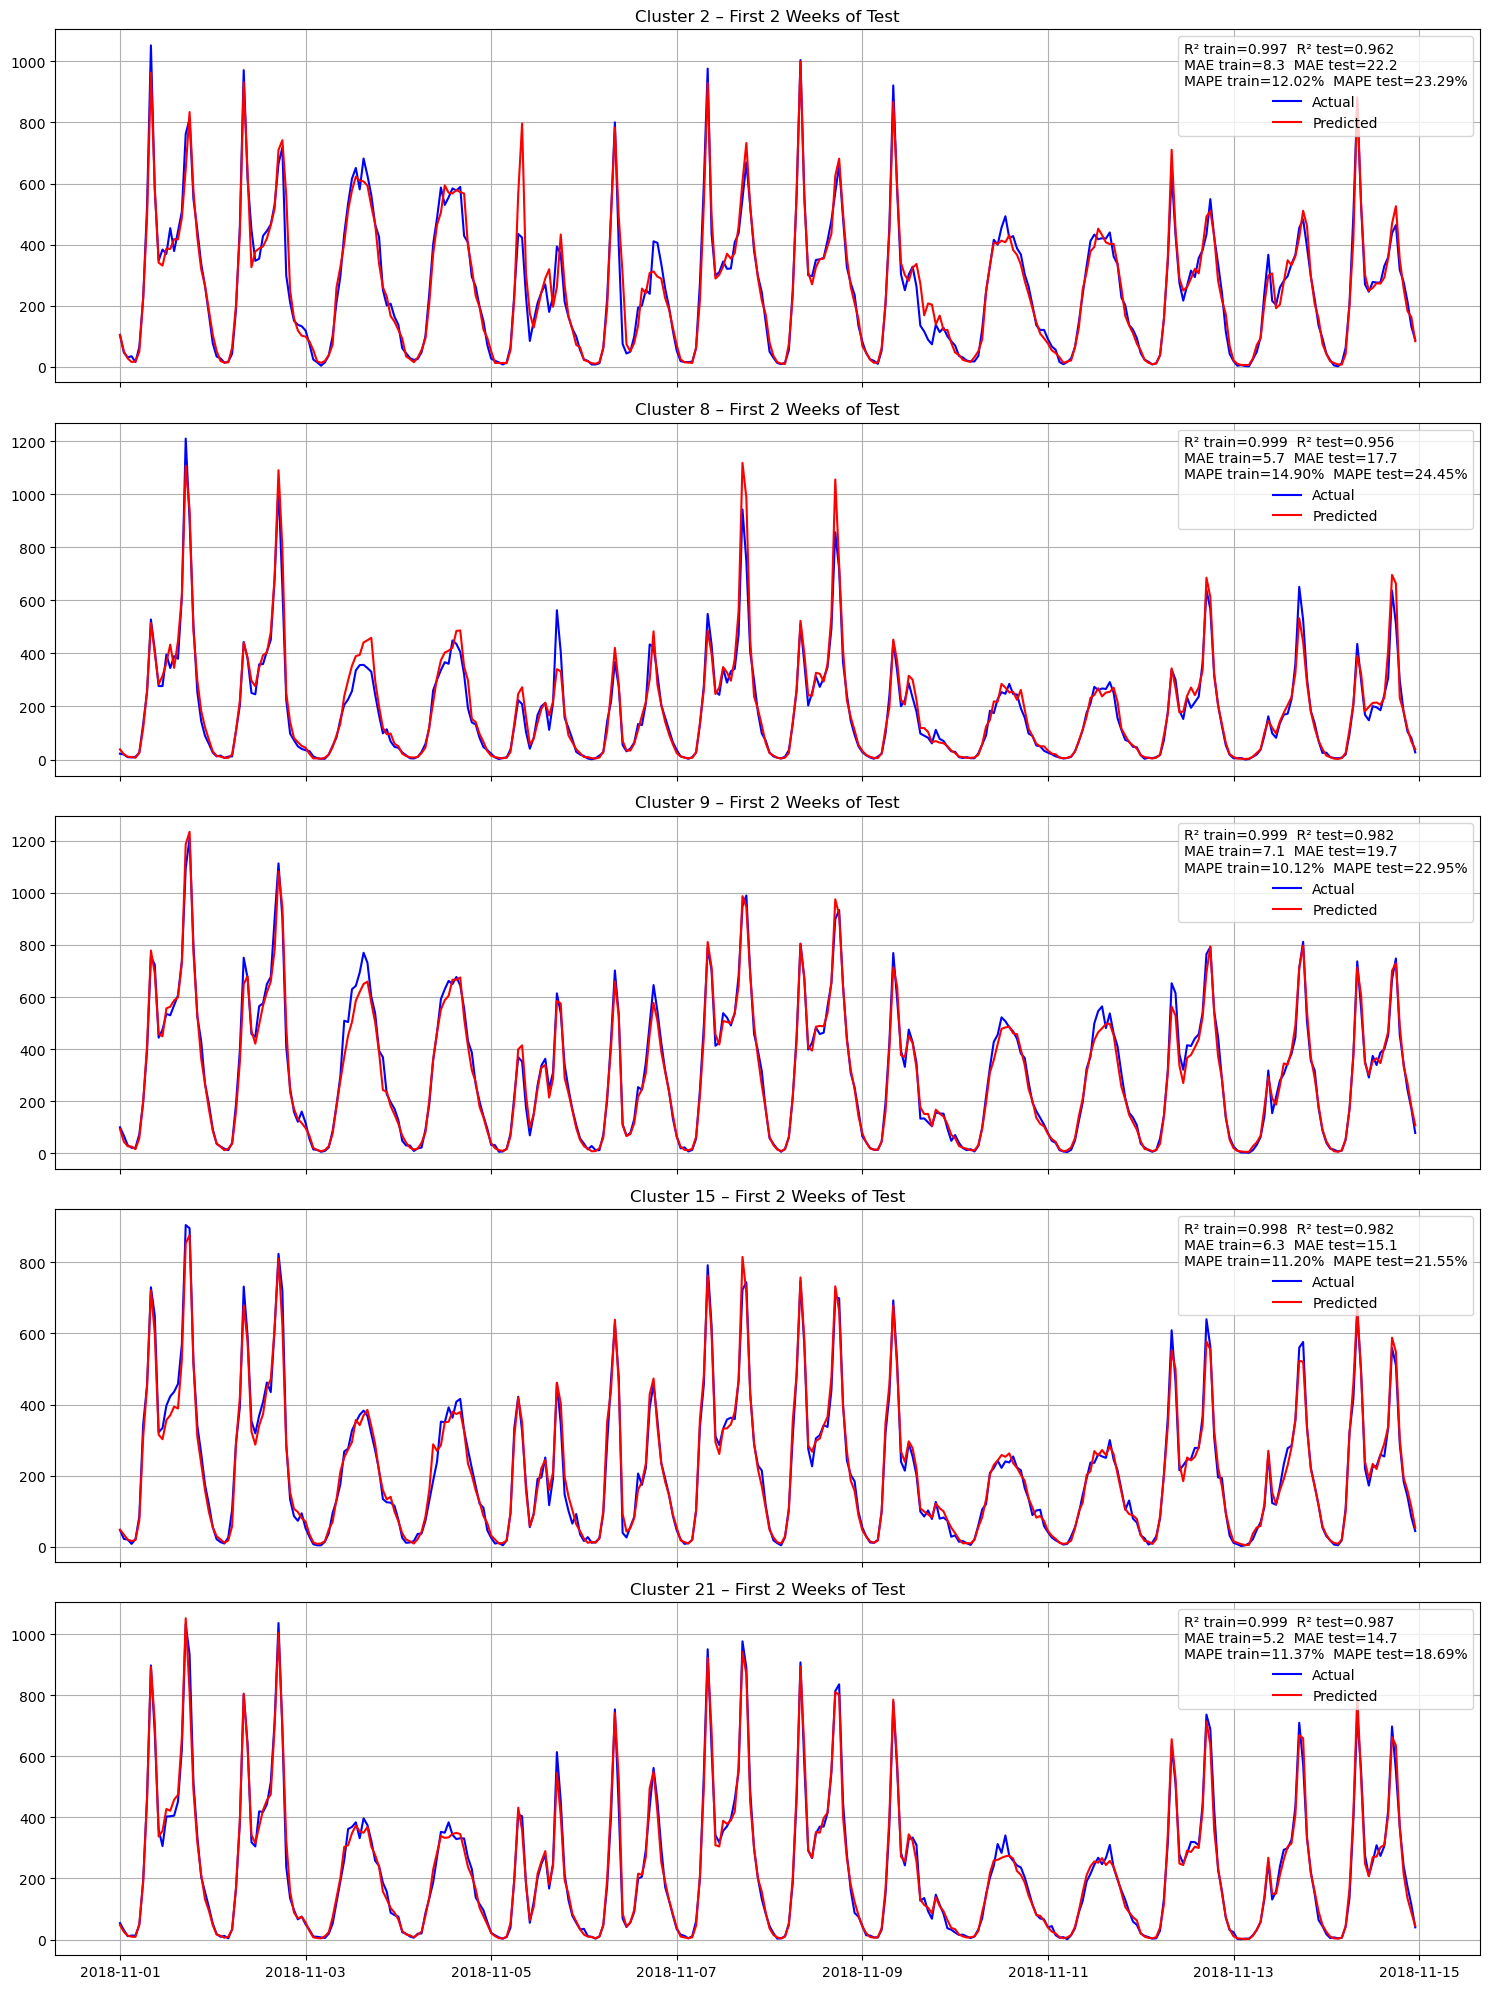

In [172]:

# First 2-week window
start_date = pickup_test.index.get_level_values('timestamp').min()
end_date = start_date + pd.Timedelta(days=14)

fig, axes = plt.subplots(len(clusters), 1, figsize=(15, 4*len(clusters)), sharex=True)

for i, cluster in enumerate(clusters):
    
    df_test = pickup_test.xs(cluster, level='start_cluster')
    df_two_weeks = df_test.loc[(df_test.index >= start_date) & (df_test.index < end_date)]
    
    pred_series = pd.Series(
        lgb_predictions_test[cluster],
        index=df_test.index
    ).loc[df_two_weeks.index]
    
    axes[i].plot(df_two_weeks.index, df_two_weeks['count'], label="Actual", color="blue")
    axes[i].plot(df_two_weeks.index, pred_series, label="Predicted", color="red")
    
    # Add metrics in legend
    m = lgb_metrics[cluster]
    axes[i].legend(title=(
        f"R² train={m['r2_train']:.3f}  R² test={m['r2_test']:.3f}\n"
        f"MAE train={m['mae_train']:.1f}  MAE test={m['mae_test']:.1f}\n"
        f"MAPE train={m['mape_train']:.2%}  MAPE test={m['mape_test']:.2%}"
    ))
    
    axes[i].set_title(f"Cluster {cluster} – First 2 Weeks of Test")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


3) Overnight, the bike-sharing company manually repositions its bikes to ensure that
demand for the next day can be met. You are expected to use the outputs from the
prediction model above to compute the required number of bicycles to be placed in
each cluster of stations analyzed in Task 2 at the beginning of the next day. To
compute this number, you can use the cumulative of the arrivals and departures. The
goal is to ensure that, over the duration of the next day, there will never be a shortage
of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The
number of bicycles required can be estimated by extrapolating the maximum
difference between the number of departures and arrivals.